# Load dữ liệu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Danh sách file (Key ngắn gọn : Tên file thực tế)
files = {
    'app_train': 'application_train.csv',
    'app_test': 'application_test.csv',
    'bureau': 'bureau.csv',
    'bureau_bal': 'bureau_balance.csv',
    'prev_app': 'previous_application.csv',
    'pos_cash': 'POS_CASH_balance.csv',
    'installments': 'installments_payments.csv',
    'cc_bal': 'credit_card_balance.csv'
}

# Vòng lặp load dữ liệu
dfs = {} 
print("--- BẮT ĐẦU LOAD DỮ LIỆU ---")
for key, filename in files.items():
    try:
        dfs[key] = pd.read_csv(filename)
        print(f"Đã load: {key:<15} shape: {dfs[key].shape}")
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file {filename}")

print("--- HOÀN TẤT ---")

--- BẮT ĐẦU LOAD DỮ LIỆU ---
Đã load: app_train       shape: (307511, 122)
Đã load: app_test        shape: (48744, 121)
Đã load: bureau          shape: (1716428, 17)
Đã load: bureau_bal      shape: (27299925, 3)
Đã load: prev_app        shape: (1670214, 37)
Đã load: pos_cash        shape: (10001358, 8)
Đã load: installments    shape: (13605401, 8)
Đã load: cc_bal          shape: (3840312, 23)
--- HOÀN TẤT ---


In [3]:
import numpy as np
import pandas as pd
import gc

def process_application_phase1(dfs):
    print("--- BẮT ĐẦU MỤC 1: XỬ LÝ BẢNG CHÍNH (APPLICATION) ---")
    
    # 1. Lấy dữ liệu từ dictionary đã load
    df_train = dfs['app_train'].copy()
    df_test = dfs['app_test'].copy()
    
    # 2. Xử lý dị thường: CODE_GENDER
    # Chỉ xóa trong tập Train để đảm bảo an toàn, Test giữ nguyên (nếu có lỗi thì kệ hoặc fill sau)
    print(f"   Shape Train trước khi lọc Gender: {df_train.shape}")
    df_train = df_train[df_train['CODE_GENDER'] != 'XNA']
    print(f"   Shape Train sau khi lọc Gender: {df_train.shape}")
    
    # 3. Gộp Train và Test
    # Reset index để tránh trùng lặp index khi gộp
    df = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)
    
    # 4. Xử lý dị thường: DAYS_EMPLOYED
    # Giá trị 365243 nghĩa là "Về hưu" hoặc lỗi -> Thay bằng NaN
    # Tạo cờ báo hiệu trước khi thay thế để giữ lại thông tin này
    df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # 5. Feature Engineering: Xử lý Tương quan & Domain Knowledge
    
    # 5.1. Xử lý cặp AMT_CREDIT và AMT_GOODS_PRICE (Tương quan cao)
    # Thay vì xóa, ta tạo biến chênh lệch (Down Payment) và Tỷ lệ
    df['NEW_DOWN_PAYMENT'] = df['AMT_GOODS_PRICE'] - df['AMT_CREDIT']
    df['NEW_GOODS_TO_CREDIT_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
    
    # 5.2. Các tỷ lệ tài chính quan trọng
    # Tỷ lệ Nợ / Thu nhập (Vay quá nhiều so với lương?)
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # Tỷ lệ Trả góp / Thu nhập (Gánh nặng hàng tháng)
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    
    # Thời gian trả nợ giả định (Tín dụng / Trả góp hàng tháng)
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    
    # Tỷ lệ thời gian đi làm / Tuổi đời (Ổn định công việc)
    df['NEW_EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    # 6. Dọn dẹp bộ nhớ
    del df_train, df_test
    gc.collect()
    
    print(f"   -> Hoàn tất Mục 1. Shape hiện tại của Master Table: {df.shape}")
    return df

# --- THỰC THI ---
# Biến df này sẽ là Master Table dùng xuyên suốt các bước sau
df = process_application_phase1(dfs)

--- BẮT ĐẦU MỤC 1: XỬ LÝ BẢNG CHÍNH (APPLICATION) ---
   Shape Train trước khi lọc Gender: (307511, 122)
   Shape Train sau khi lọc Gender: (307507, 122)
   -> Hoàn tất Mục 1. Shape hiện tại của Master Table: (356251, 129)


In [4]:
import pandas as pd
import numpy as np
import gc

# Hàm One-Hot Encoder dùng chung (Cực kỳ quan trọng)
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def process_bureau_and_balance(df, dfs):
    print("--- BẮT ĐẦU MỤC 2: XỬ LÝ BUREAU & BUREAU BALANCE ---")
    
    bureau = dfs['bureau'].copy()
    bureau_bal = dfs['bureau_bal'].copy()
    
    # -----------------------------------------------------
    # 2.1. Xử lý Bureau Balance (Chi tiết từng tháng của khoản vay)
    # -----------------------------------------------------
    print("   -> Đang xử lý Bureau Balance...")
    bb, bb_cat = one_hot_encoder(bureau_bal, nan_as_category=True)
    
    # Tính tỷ lệ các trạng thái (Status) cho từng SK_ID_BUREAU
    bb_agg = bb.groupby('SK_ID_BUREAU').agg('mean')
    
    # Đổi tên cột để tránh trùng lặp: STATUS_0 -> BB_STATUS_0
    bb_agg.columns = pd.Index([col.upper() + '_MEAN' for col in bb_agg.columns])
    
    # Nối thông tin Balance vào bảng Bureau gốc
    bureau = bureau.join(bb_agg, on='SK_ID_BUREAU', how='left')
    
    # Dọn dẹp RAM ngay
    del bureau_bal, bb, bb_agg
    gc.collect()
    
    # -----------------------------------------------------
    # 2.2. Xử lý bảng Bureau (Lịch sử tín dụng tổng quan)
    # -----------------------------------------------------
    print("   -> Đang xử lý Bureau...")
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)
    
    # A. Danh sách các cột số cần tính toán
    # Các quy tắc aggregate:
    # - DAYS_... (Ngày): Cần biết Min (gần nhất), Max (xa nhất), Var (độ biến động)
    # - AMT_... (Tiền): Cần biết Max (vay nhiều nhất), Sum (tổng nợ), Mean
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum']
    }
    
    # B. Các cột One-hot (Category) -> Chỉ tính Mean (để ra tỷ lệ %)
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    # Thêm các cột từ Balance (đã có chữ MEAN) vào để tính Mean lần nữa (Mean của Mean)
    for col in bureau.columns:
        if 'STATUS' in col and 'MEAN' in col:
            cat_aggregations[col] = ['mean']
            
    # --- GOM NHÓM CHUNG (TOÀN BỘ LỊCH SỬ) ---
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    
    # Đổi tên cột chuẩn (Viết hoa, nối bằng dấu gạch dưới)
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # -----------------------------------------------------
    # 2.3. Tách biệt: Chỉ tính thống kê cho các khoản vay ACTIVE (Đang nợ)
    # -----------------------------------------------------
    # Lý do: Người có lịch sử nợ xấu cũ (Closed) khác với người đang gánh nợ hiện tại (Active)
    print("   -> Đang tính toán riêng cho Active Loans...")
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    
    # Với Active, ta quan tâm: Còn bao nhiêu ngày, Tổng nợ còn lại, Số lần gia hạn
    active_agg = active.groupby('SK_ID_CURR').agg({
        'DAYS_CREDIT': ['mean', 'var'],
        'AMT_CREDIT_SUM': ['sum'],
        'AMT_CREDIT_SUM_DEBT': ['sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum']
    })
    
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    
    # Tương tự cho Closed (Đã đóng) - Để xem lịch sử trả nợ tốt hay không
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg({
        'AMT_CREDIT_SUM': ['sum'],
        'DAYS_CREDIT': ['var']
    })
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    
    # -----------------------------------------------------
    # 2.4. Merge tất cả vào Master Table
    # -----------------------------------------------------
    print("   -> Đang Merge vào bảng chính...")
    df = df.join(bureau_agg, on='SK_ID_CURR', how='left')
    df = df.join(active_agg, on='SK_ID_CURR', how='left')
    df = df.join(closed_agg, on='SK_ID_CURR', how='left')
    
    # Dọn dẹp bộ nhớ lần cuối
    del bureau, bureau_agg, active, active_agg, closed, closed_agg
    gc.collect()
    
    print(f"   -> Hoàn tất Mục 2. Shape hiện tại: {df.shape}")
    return df

# --- THỰC THI ---
# Tiếp tục cập nhật biến df
df = process_bureau_and_balance(df, dfs)

--- BẮT ĐẦU MỤC 2: XỬ LÝ BUREAU & BUREAU BALANCE ---
   -> Đang xử lý Bureau Balance...
   -> Đang xử lý Bureau...
   -> Đang tính toán riêng cho Active Loans...
   -> Đang Merge vào bảng chính...
   -> Hoàn tất Mục 2. Shape hiện tại: (356251, 195)


In [5]:
import pandas as pd
import numpy as np
import gc

def process_previous_applications(df, dfs):
    print("--- BẮT ĐẦU MỤC 3: XỬ LÝ PREVIOUS APPLICATIONS ---")
    
    prev = dfs['prev_app'].copy()
    
    # 3.1. Làm sạch dữ liệu (Data Cleaning)
    # Các cột ngày tháng trong bảng này cũng bị lỗi 365243 -> Thay bằng NaN
    days_cols = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    
    for col in days_cols:
        prev[col].replace(365243, np.nan, inplace=True)
    
    # 3.2. Feature Engineering (Tạo biến mới)
    # Tỷ lệ: Số tiền ĐƯỢC CẤP / Số tiền XIN VAY
    # Nếu > 1: Được cấp nhiều hơn xin (Uy tín cao)
    # Nếu < 1: Bị cắt giảm (Uy tín thấp)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # 3.3. One-Hot Encoding
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    
    # 3.4. Aggregation (Thống kê chung cho toàn bộ lịch sử)
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'], # Ngày nộp đơn (càng gần 0 càng mới)
        'CNT_PAYMENT': ['mean', 'sum'], # Kỳ hạn vay
    }
    
    # Với biến category, ta tính Mean (để ra tỷ lệ)
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    print("   -> Đang tính toán thống kê chung (General Aggregation)...")
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    
    # Đổi tên cột chuẩn: PREV_ + tên biến
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # 3.5. Aggregation nâng cao: Tách riêng Approved và Refused
    # Lý do: Hành vi của những lần bị TỪ CHỐI quan trọng hơn những lần bình thường
    
    # --- A. Lọc hồ sơ được duyệt (Approved) ---
    print("   -> Đang tính toán cho hồ sơ Approved...")
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg({
        'AMT_ANNUITY': ['mean'],
        'AMT_CREDIT': ['mean', 'max'],
        'DAYS_DECISION': ['mean', 'max'], # max: Lần duyệt gần nhất là khi nào
        'CNT_PAYMENT': ['mean', 'sum']
    })
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    
    # --- B. Lọc hồ sơ bị từ chối (Refused) ---
    print("   -> Đang tính toán cho hồ sơ Refused...")
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg({
        'AMT_APPLICATION': ['mean', 'max'], # Họ thường xin bao nhiêu thì bị từ chối?
        'DAYS_DECISION': ['mean', 'max'],   # Lần từ chối gần nhất
        'cnt_payment': ['mean']             # (Lưu ý: cột này có thể NaN với hồ sơ refused, nhưng cứ giữ để check)
    }) if 'cnt_payment' in refused.columns else refused.groupby('SK_ID_CURR').agg({
         'AMT_APPLICATION': ['mean', 'max'],
         'DAYS_DECISION': ['mean', 'max']
    })
    
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    
    # 3.6. Merge tất cả vào Master Table
    df = df.join(prev_agg, on='SK_ID_CURR', how='left')
    df = df.join(approved_agg, on='SK_ID_CURR', how='left')
    df = df.join(refused_agg, on='SK_ID_CURR', how='left')
    
    # Dọn dẹp
    del prev, prev_agg, approved, approved_agg, refused, refused_agg
    gc.collect()
    
    print(f"   -> Hoàn tất Mục 3. Shape hiện tại: {df.shape}")
    return df

# --- THỰC THI ---
df = process_previous_applications(df, dfs)

--- BẮT ĐẦU MỤC 3: XỬ LÝ PREVIOUS APPLICATIONS ---
   -> Đang tính toán thống kê chung (General Aggregation)...
   -> Đang tính toán cho hồ sơ Approved...
   -> Đang tính toán cho hồ sơ Refused...
   -> Hoàn tất Mục 3. Shape hiện tại: (356251, 395)


In [6]:
import pandas as pd
import numpy as np
import gc

def process_pos_and_installments(df, dfs):
    print("--- BẮT ĐẦU MỤC 4 & 5: POS CASH & INSTALLMENTS ---")
    
    # =========================================================================
    # MỤC 4: POS_CASH_balance (Vay tiền mặt/tiêu dùng tại điểm bán)
    # =========================================================================
    print("1. Đang xử lý POS_CASH_balance...")
    pos = dfs['pos_cash'].copy()
    
    # One-Hot Encoding cho trạng thái hợp đồng
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Aggregation
    # SK_DPD: Số ngày quá hạn (quan trọng) -> Lấy Max để xem từng trễ hạn nặng nhất bao nhiêu
    # CNT_INSTALMENT_FUTURE: Số kỳ còn lại -> Mean
    aggregations = {
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        'CNT_INSTALMENT': ['min', 'max', 'mean'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean']
    }
    
    # Với biến category (NAME_CONTRACT_STATUS...), lấy Mean
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Merge vào bảng chính
    df = df.join(pos_agg, on='SK_ID_CURR', how='left')
    
    del pos, pos_agg
    gc.collect()

    # =========================================================================
    # MỤC 5: installments_payments (Lịch sử trả góp - QUAN TRỌNG NHẤT)
    # =========================================================================
    print("2. Đang xử lý Installments Payments...")
    ins = dfs['installments'].copy()
    
    # 5.1. Feature Engineering (Tính toán trên từng dòng trước)
    # Tỷ lệ số tiền trả so với số tiền phải trả
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    
    # Chênh lệch số tiền (Trả thiếu hay dư?)
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Chênh lệch ngày (Trả sớm hay muộn?)
    # DAYS_ENTRY_PAYMENT: Ngày trả thực tế
    # DAYS_INSTALMENT: Ngày phải trả theo kế hoạch
    # Nếu dương -> Trả muộn (DPD). Nếu âm -> Trả sớm (DBD).
    ins['DAYS_DIFF'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DPD'] = ins['DAYS_DIFF'].apply(lambda x: x if x > 0 else 0) # Days Past Due
    ins['DBD'] = ins['DAYS_DIFF'].apply(lambda x: -x if x < 0 else 0) # Days Before Due
    
    # 5.2. Aggregation
    aggregations = {
        'PAYMENT_PERC': ['max', 'mean', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'var', 'sum'],
        'DPD': ['max', 'mean', 'sum'], # Tổng số ngày trễ, lần trễ lâu nhất
        'DBD': ['max', 'mean', 'sum'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'min']
    }
    
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # 5.3. Đếm số lần trả trễ hạn (Count Late Payments)
    # Tạo một biến cờ (1 nếu trễ, 0 nếu đúng hạn)
    ins['IS_LATE'] = ins['DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Gom nhóm tính tổng số lần trễ
    ins_late_count = ins.groupby('SK_ID_CURR')['IS_LATE'].sum()
    
    # Merge vào bảng chính
    df = df.join(ins_agg, on='SK_ID_CURR', how='left')
    df['INSTAL_COUNT_LATE'] = df['SK_ID_CURR'].map(ins_late_count)
    
    del ins, ins_agg, ins_late_count
    gc.collect()
    
    print(f"   -> Hoàn tất Mục 4 & 5. Shape hiện tại: {df.shape}")
    return df

# --- THỰC THI ---
df = process_pos_and_installments(df, dfs)

--- BẮT ĐẦU MỤC 4 & 5: POS CASH & INSTALLMENTS ---
1. Đang xử lý POS_CASH_balance...
2. Đang xử lý Installments Payments...
   -> Hoàn tất Mục 4 & 5. Shape hiện tại: (356251, 439)


In [7]:
import pandas as pd
import numpy as np
import gc
import re # Thư viện xử lý chuỗi regex

def process_credit_card_and_final_cleanup(df, dfs):
    print("--- BẮT ĐẦU MỤC 6: CREDIT CARD BALANCE ---")
    
    cc = dfs['cc_bal'].copy()
    
    # 6.1. One-Hot Encoding
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    
    # 6.2. Feature Engineering & Aggregation
    # Cần tính toán riêng một số feature đặc thù của thẻ tín dụng
    
    # Xử lý các dòng có dữ liệu nhưng Balance/Drawings = 0 để tránh nhiễu
    cc.replace(0, np.nan, inplace=True) # Tạm thay 0 bằng NaN để tính Mean chính xác hơn (tùy chọn)
    
    aggregations = {
        'AMT_BALANCE': ['min', 'max', 'mean', 'sum', 'var'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean', 'sum'],
        'AMT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum'], # Rút tiền mặt
        'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum'],      # Tổng rút
        'AMT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum'],  # Quẹt thẻ
        'AMT_INST_MIN_REGULARITY': ['min', 'max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean'],
        'AMT_TOTAL_RECEIVABLE': ['min', 'max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],      # Ngày quá hạn
        'SK_DPD_DEF': ['mean', 'max', 'sum']
    }
    
    # Tính Mean cho các biến Category
    for cat in cat_cols:
        aggregations[cat] = ['mean']
        
    cc_agg = cc.groupby('SK_ID_CURR').agg(aggregations)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # 6.3. Tính số lượng thẻ tín dụng (Count)
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    # Merge vào bảng chính
    print("   -> Merge Credit Card vào bảng chính...")
    df = df.join(cc_agg, on='SK_ID_CURR', how='left')
    
    del cc, cc_agg
    gc.collect()
    
    # =========================================================================
    # MỤC 7: FINAL CLEANUP (HOÀN THIỆN)
    # =========================================================================
    print("--- BẮT ĐẦU MỤC 7: DỌN DẸP CUỐI CÙNG (FINAL CLEANUP) ---")
    
    # 7.1. Đổi tên cột cho chuẩn LightGBM/XGBoost
    # LightGBM KHÔNG chấp nhận tên cột có chứa: khoảng trắng, dấu phẩy, dấu ngoặc, dấu hai chấm
    # Chúng ta dùng Regex để thay thế tất cả ký tự lạ bằng dấu gạch dưới (_)
    print("   -> Đang chuẩn hóa tên cột (Rename for LightGBM)...")
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    
    # 7.2. Xử lý giá trị Vô cực (Infinity)
    # Các phép chia cho 0 khi tạo feature sẽ sinh ra inf hoặc -inf.
    # Thay thế inf bằng NaN
    print("   -> Đang xử lý giá trị vô cực (Infinity)...")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 7.3. Xóa các cột vô nghĩa (Chỉ có 1 giá trị duy nhất) - Như đã bàn trước đó
    # Đây là lúc an toàn nhất để xóa
    print("   -> Đang quét các cột hằng số (Constant columns)...")
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    if len(cols_to_drop) > 0:
        print(f"      Đã xóa {len(cols_to_drop)} cột hằng số.")
        df.drop(cols_to_drop, axis=1, inplace=True)
    
    # 7.4. Tách lại tập Train và Test
    # Lúc đầu ta gộp lại để xử lý, giờ tách ra dựa vào dòng có TARGET (Train) và không có (Test)
    # Tuy nhiên, để tiện cho bước sau (chia pipeline), ta có thể giữ nguyên df
    # hoặc tách ra ngay tại đây.
    # Theo yêu cầu của bạn là "chia 2 pipeline", tôi sẽ giữ nguyên df lớn
    # và chỉ tách khi bắt đầu training.
    
    print(f"--- HOÀN TẤT TOÀN BỘ QUÁ TRÌNH TIỀN XỬ LÝ DÙNG CHUNG ---")
    print(f"SHAPE CUỐI CÙNG: {df.shape}")
    
    return df

# --- THỰC THI ---
df = process_credit_card_and_final_cleanup(df, dfs)

--- BẮT ĐẦU MỤC 6: CREDIT CARD BALANCE ---
   -> Merge Credit Card vào bảng chính...
--- BẮT ĐẦU MỤC 7: DỌN DẸP CUỐI CÙNG (FINAL CLEANUP) ---
   -> Đang chuẩn hóa tên cột (Rename for LightGBM)...
   -> Đang xử lý giá trị vô cực (Infinity)...
   -> Đang quét các cột hằng số (Constant columns)...
      Đã xóa 20 cột hằng số.
--- HOÀN TẤT TOÀN BỘ QUÁ TRÌNH TIỀN XỬ LÝ DÙNG CHUNG ---
SHAPE CUỐI CÙNG: (356251, 473)


Tên cột: Đã được chuẩn hóa (ví dụ: Client's Age thành Client_s_Age).

Dữ liệu: Không còn inf, chứa đầy đủ features từ tất cả các bảng.

Missing Value: Vẫn còn giữ nguyên NaN (để cho Random Forest xử lý riêng và XGB/LGBM xử lý riêng).

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import gc

def prepare_data_final(df):
    print("--- BẮT ĐẦU GIAI ĐOẠN: CHUẨN BỊ DỮ LIỆU CUỐI CÙNG ---")
    
    # ---------------------------------------------------------
    # 1. TÁCH DỮ LIỆU CƠ BẢN
    # ---------------------------------------------------------
    print("1. Tách Train/Test và Target...")
    
    # Tách dựa trên cột TARGET (Train có giá trị, Test là NaN)
    train_df = df[df['TARGET'].notnull()].copy()
    test_df = df[df['TARGET'].isnull()].copy()
    
    # Tách biến mục tiêu (Target)
    y = train_df['TARGET']
    
    # Tách ID (Lưu lại riêng để dùng cho file submission sau này)
    train_ids = train_df['SK_ID_CURR']
    test_ids = test_df['SK_ID_CURR']
    
    # Tạo feature matrix X (Loại bỏ Target và ID)
    X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
    X_test = test_df.drop(columns=['TARGET', 'SK_ID_CURR'])
    
    # Xóa df gốc để giải phóng RAM ngay lập tức
    del df, train_df, test_df
    gc.collect()
    
    print(f"   -> Train shape: {X.shape}")
    print(f"   -> Test shape:  {X_test.shape}")
    
    # ---------------------------------------------------------
    # 2. MÃ HÓA BIẾN PHÂN LOẠI (LABEL ENCODING)
    # ---------------------------------------------------------
    print("2. Label Encoding (Chuyển chuỗi sang số)...")
    
    # Tìm các cột còn ở dạng Object (chữ)
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    print(f"   -> Tìm thấy {len(cat_cols)} biến cần mã hóa.")
    
    # Loop qua từng cột để encode
    for col in cat_cols:
        le = LabelEncoder()
        # Chuyển sang string để tránh lỗi
        train_values = X[col].astype(str)
        test_values = X_test[col].astype(str)
        
        # Fit trên cả Train và Test để đảm bảo không bị lỗi "Unseen label"
        le.fit(pd.concat([train_values, test_values]))
        
        X[col] = le.transform(train_values)
        X_test[col] = le.transform(test_values)
        
    print("   -> Hoàn tất Encoding.")

    # ---------------------------------------------------------
    # 3. PHÂN NHÁNH DỮ LIỆU (DATA BRANCHING)
    # ---------------------------------------------------------
    print("3. Phân nhánh dữ liệu cho các mô hình...")
    
    # --- NHÁNH A: Dành cho XGBoost & LightGBM ---
    # Giữ nguyên Missing Values (NaN) vì 2 model này xử lý tốt
    X_lgbm = X.copy()
    X_test_lgbm = X_test.copy()
    print("   -> [Nhánh A] Dữ liệu cho XGB/LGBM: Sẵn sàng (giữ nguyên NaN).")
    
    # --- NHÁNH B: Dành cho Random Forest ---
    # Random Forest (sklearn) không chạy được nếu có NaN -> Phải điền (Impute)
    print("   -> [Nhánh B] Đang xử lý NaN cho Random Forest (Imputing)...")
    
    # Dùng Median (Trung vị) để điền, hạn chế ảnh hưởng của outliers
    imputer = SimpleImputer(strategy='median')
    
    # Fit trên Train
    imputer.fit(X)
    
    # Transform (Lưu ý: imputer trả về numpy array, cần chuyển lại DataFrame để giữ tên cột)
    X_rf = pd.DataFrame(imputer.transform(X), columns=X.columns)
    X_test_rf = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    
    # Ép kiểu lại để tiết kiệm RAM (Imputer hay trả về float64, chuyển về float32)
    X_rf = X_rf.astype(np.float32)
    X_test_rf = X_test_rf.astype(np.float32)
    
    print("   -> [Nhánh B] Dữ liệu cho Random Forest: Sẵn sàng (NaN filled).")

    # ---------------------------------------------------------
    # 4. CHUẨN BỊ THAM SỐ CÂN BẰNG (IMBALANCED PARAM)
    # ---------------------------------------------------------
    print("4. Tính toán tham số cân bằng mẫu...")
    count_0 = (y == 0).sum()
    count_1 = (y == 1).sum()
    scale_pos_weight = count_0 / count_1
    
    print(f"   Target 0 (Tốt): {count_0}")
    print(f"   Target 1 (Xấu): {count_1}")
    print(f"   Tỷ lệ (Scale Pos Weight): {scale_pos_weight:.4f}")
    
    # Dọn dẹp RAM lần cuối
    del X, X_test
    gc.collect()

    print("--- HOÀN TẤT CHUẨN BỊ DỮ LIỆU ---")
    
    # Trả về dictionary chứa mọi thứ cần thiết
    return {
        'y': y,
        'train_ids': train_ids,
        'test_ids': test_ids,
        'X_lgbm': X_lgbm,         # Input cho XGBoost/LightGBM
        'X_test_lgbm': X_test_lgbm, # Để submit
        'X_rf': X_rf,             # Input cho Random Forest
        'X_test_rf': X_test_rf,     # Để submit
        'scale_pos_weight': scale_pos_weight
    }

# --- THỰC THI CODE ---
# Biến 'data' này sẽ được dùng cho phần Training kế tiếp
data = prepare_data_final(df)

--- BẮT ĐẦU GIAI ĐOẠN: CHUẨN BỊ DỮ LIỆU CUỐI CÙNG ---
1. Tách Train/Test và Target...
   -> Train shape: (307507, 471)
   -> Test shape:  (48744, 471)
2. Label Encoding (Chuyển chuỗi sang số)...
   -> Tìm thấy 16 biến cần mã hóa.
   -> Hoàn tất Encoding.
3. Phân nhánh dữ liệu cho các mô hình...
   -> [Nhánh A] Dữ liệu cho XGB/LGBM: Sẵn sàng (giữ nguyên NaN).
   -> [Nhánh B] Đang xử lý NaN cho Random Forest (Imputing)...
   -> [Nhánh B] Dữ liệu cho Random Forest: Sẵn sàng (NaN filled).
4. Tính toán tham số cân bằng mẫu...
   Target 0 (Tốt): 282682
   Target 1 (Xấu): 24825
   Tỷ lệ (Scale Pos Weight): 11.3870
--- HOÀN TẤT CHUẨN BỊ DỮ LIỆU ---


PHẦN 1: HÀM TÍNH TOÁN CHỈ SỐ (METRICS ENGINE)

In [9]:
import numpy as np  # <--- Bổ sung dòng này
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score
from scipy.stats import ks_2samp

def calculate_metrics(y_true, y_prob, model_name="Model", plot_cm=False):
    """
    Hàm tính toán toàn bộ chỉ số đánh giá: AUC, Gini, KS, F1, Precision, Recall
    """
    # Chuyển đổi sang numpy array để tránh lỗi index nếu input là pandas series
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # 1. Nhóm Hiệu suất Mô hình (Performance)
    auc = roc_auc_score(y_true, y_prob)
    
    # 2. Nhóm Hiệu quả Nghiệp vụ (Business)
    # Gini = 2 * AUC - 1
    gini = 2 * auc - 1
    
    # Chỉ số KS (Kolmogorov-Smirnov)
    # Tách xác suất của nhóm Positive (1) và Negative (0)
    prob_pos = y_prob[y_true == 1]
    prob_neg = y_prob[y_true == 0]
    ks_stat, _ = ks_2samp(prob_pos, prob_neg)
    
    # 3. Tìm Ngưỡng tối ưu (Optimal Threshold) dựa trên F1-Score
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Tính F1 cho mọi ngưỡng cắt
    # Thêm epsilon nhỏ để tránh chia cho 0
    numerator = 2 * (precision * recall)
    denominator = precision + recall
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # Lấy ngưỡng có F1 cao nhất
    best_idx = np.argmax(f1_scores)
    # threshold của sklearn ngắn hơn precision/recall 1 phần tử, cần xử lý index
    if best_idx < len(thresholds):
        best_thresh = thresholds[best_idx]
    else:
        best_thresh = thresholds[-1]
        
    best_f1 = f1_scores[best_idx]
    
    # Tạo dự đoán nhãn (0/1) dựa trên ngưỡng tối ưu này
    y_pred_binary = (y_prob >= best_thresh).astype(int)
    
    # Tính các chỉ số còn lại
    prec = precision_score(y_true, y_pred_binary, zero_division=0)
    rec = recall_score(y_true, y_pred_binary, zero_division=0)
    cm = confusion_matrix(y_true, y_pred_binary)
    
    # In kết quả
    print(f"--- ĐÁNH GIÁ HIỆU SUẤT: {model_name} ---")
    print(f"1. ROC-AUC:   {auc:.4f}")
    print(f"2. Gini:      {gini:.4f}")
    print(f"3. KS Stat:   {ks_stat:.4f}")
    print(f"--- Tại ngưỡng tối ưu (Threshold = {best_thresh:.4f}) ---")
    print(f"4. F1-Score:  {best_f1:.4f}")
    print(f"5. Precision: {prec:.4f}")
    print(f"6. Recall:    {rec:.4f}")
    print("-" * 30)
    
    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix ({model_name})\nThreshold={best_thresh:.3f}")
        plt.ylabel("Thực tế")
        plt.xlabel("Dự đoán")
        plt.show()

    return {
        'auc': auc, 'gini': gini, 'ks': ks_stat, 
        'f1': best_f1, 'threshold': best_thresh
    }

PHẦN 2: HÀM HUẤN LUYỆN K-FOLD (TRAINING ENGINE)

In [10]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb

def train_with_kfold(model, X, y, model_type='sklearn'):
    """
    model: Model object (đã khởi tạo tham số)
    X, y: Dữ liệu (Dùng đúng loại: X_rf cho RF, X_lgbm cho XGB/LGBM)
    model_type: 'sklearn' (cho RF) hoặc 'gbdt' (cho XGB/LGBM có early stopping)
    """
    # K-Fold: 5 fold
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Mảng lưu kết quả dự đoán OOF (Out-of-Fold) cho toàn bộ tập train
    oof_preds = np.zeros(X.shape[0])
    
    # Lưu điểm AUC từng fold để tính trung bình
    fold_aucs = []
    
    print(f"Bắt đầu Training {model.__class__.__name__} với 5 Folds...")
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        # Chia dữ liệu
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
        
        # Huấn luyện
        if model_type == 'sklearn':
            # Với Random Forest
            model.fit(X_train, y_train)
            # Predict Proba (lấy cột xác suất nhãn 1)
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            
        elif model_type == 'lgbm':
            # Với LightGBM (cần setup early stopping)
            callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=False), lgb.log_evaluation(period=0)]
            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_metric='auc',
                callbacks=callbacks
            )
            y_pred_valid = model.predict_proba(X_valid)[:, 1]

        elif model_type == 'xgboost':
            # Với XGBoost
            model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                verbose=False
            )
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            
        # Lưu kết quả dự đoán vào mảng OOF
        oof_preds[valid_idx] = y_pred_valid
        
        # Tính AUC sơ bộ cho fold này
        fold_auc = roc_auc_score(y_valid, y_pred_valid)
        fold_aucs.append(fold_auc)
        print(f"   Fold {n_fold+1}: AUC = {fold_auc:.4f}")

    print(f"\n--> Trung bình AUC 5-Folds: {np.mean(fold_aucs):.4f}")
    
    # Tính toán toàn bộ chỉ số trên tập OOF (Tổng hợp)
    # Đây là kết quả đáng tin cậy nhất
    final_metrics = calculate_metrics(y, oof_preds, model_name=model.__class__.__name__, plot_cm=True)
    
    return model, oof_preds, final_metrics

PHẦN 3: THỰC THI (RUNNING)

1. Huấn luyện Random Forest

START TRAINING: RANDOM FOREST
Bắt đầu Training RandomForestClassifier với 5 Folds...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished


   Fold 1: AUC = 0.7553


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.1s finished


   Fold 2: AUC = 0.7568


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.6s finished


   Fold 3: AUC = 0.7548


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished


   Fold 4: AUC = 0.7590


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.1s finished


   Fold 5: AUC = 0.7525

--> Trung bình AUC 5-Folds: 0.7557
--- ĐÁNH GIÁ HIỆU SUẤT: RandomForestClassifier ---
1. ROC-AUC:   0.7557
2. Gini:      0.5114
3. KS Stat:   0.3814
--- Tại ngưỡng tối ưu (Threshold = 0.5313) ---
4. F1-Score:  0.3002
5. Precision: 0.2302
6. Recall:    0.4314
------------------------------


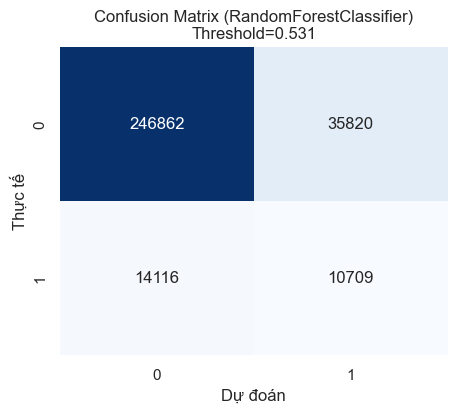

In [11]:
from sklearn.ensemble import RandomForestClassifier

print("="*40)
print("START TRAINING: RANDOM FOREST")
print("="*40)

# 1. Cấu hình Model
# Lưu ý: RF cần max_depth để không bị tràn RAM với dữ liệu lớn
rf_model = RandomForestClassifier(
    n_estimators=200,    # Số lượng cây: 200 là điểm cân bằng tốc độ/hiệu suất
    max_depth=12,        # Giới hạn độ sâu: Quan trọng để tránh Out of Memory
    min_samples_leaf=30, # Mỗi lá ít nhất 30 mẫu -> Giảm nhiễu (Overfitting)
    class_weight='balanced', # Xử lý dữ liệu lệch
    n_jobs=-1,           # Dùng 100% CPU
    random_state=42,
    verbose=1            # Hiện tiến trình
)

# 2. Chạy Training (QUAN TRỌNG: Dùng data['X_rf'] đã điền NaN)
# Lưu ý: RF chạy sẽ lâu hơn XGB/LGBM (khoảng 5-10 phút tùy máy)
rf_model, rf_oof, rf_metrics = train_with_kfold(
    rf_model, 
    data['X_rf'], 
    data['y'], 
    model_type='sklearn'
)


--- ĐANG VẼ BIỂU ĐỒ 5 FOLDS: Random Forest ---


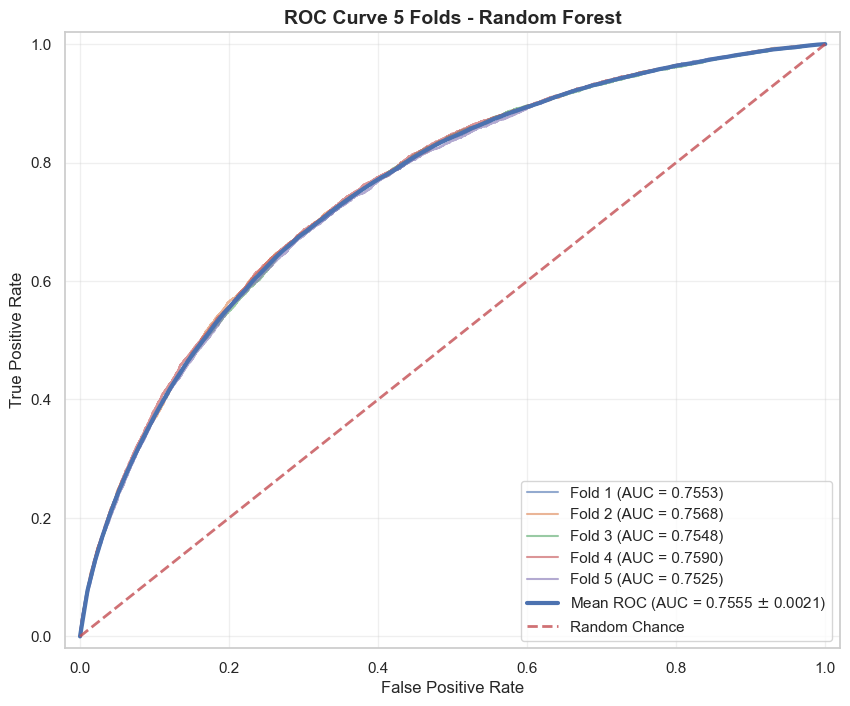

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# 1. Định nghĩa lại hàm vẽ 5 Fold (Giống hệt hàm của XGB/LGBM nãy)
def plot_roc_5folds_from_oof(y_true, oof_preds, model_name):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    plt.figure(figsize=(10, 8))
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    print(f"--- ĐANG VẼ BIỂU ĐỒ 5 FOLDS: {model_name} ---")
    
    # Lấy lại index của 5 fold để vẽ
    for n_fold, (_, valid_idx) in enumerate(folds.split(y_true, y_true)):
        y_valid_fold = y_true.iloc[valid_idx]
        y_pred_fold = oof_preds[valid_idx] 
        
        fpr, tpr, _ = roc_curve(y_valid_fold, y_pred_fold)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        plt.plot(fpr, tpr, lw=1.5, alpha=0.6, 
                 label=f'Fold {n_fold+1} (AUC = {roc_auc:.4f})')
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=f'Mean ROC (AUC = {mean_auc:.4f} $\pm$ {std_auc:.4f})',
             lw=3, alpha=1)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance', alpha=.8)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve 5 Folds - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# 2. Thực hiện vẽ cho RANDOM FOREST
# Kiểm tra xem rf_oof có tồn tại không (do bạn bảo đã chạy xong phần train)
if 'rf_oof' in globals():
    plot_roc_5folds_from_oof(data['y'], rf_oof, model_name="Random Forest")
else:
    print("Lỗi: Không tìm thấy biến 'rf_oof'.")
    print("Có vẻ phần Training Random Forest phía trên chưa chạy xong hoặc bị lỗi.")
    print("Hãy chạy lại block Training Random Forest.")

2. Huấn luyện LightGBM

START TRAINING: LIGHTGBM
Bắt đầu Training LGBMClassifier với 5 Folds...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.232078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64718
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 467
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
   Fold 1: AUC = 0.7230
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.552993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64789
[LightGBM] [Info] Number of data points in the train set: 246005, number 

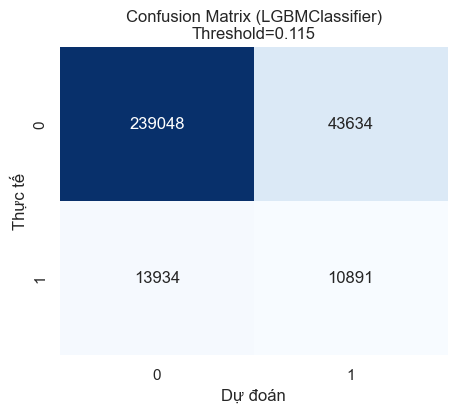

In [13]:
from lightgbm import LGBMClassifier

print("="*40)
print("START TRAINING: LIGHTGBM")
print("="*40)

# 1. Cấu hình Model
lgbm_model = LGBMClassifier(
    n_estimators=2000,       # Đặt lớn vì có Early Stopping lo việc dừng
    learning_rate=0.02,      # Học chậm để chi tiết (0.01 - 0.05 là đẹp)
    num_leaves=34,           # Độ phức tạp của cây (31-34 là chuẩn)
    max_depth=8,             # Giới hạn độ sâu
    scale_pos_weight=data['scale_pos_weight'], # Cân bằng mẫu (quan trọng)
    n_jobs=-1,               # Full CPU
    random_state=42,
    importance_type='gain'   # Để vẽ feature importance sau này
)

# 2. Chạy Training (Dùng data['X_lgbm'])
lgbm_model, lgbm_oof, lgbm_metrics = train_with_kfold(
    lgbm_model, 
    data['X_lgbm'], 
    data['y'], 
    model_type='lgbm' # Báo cho hàm biết đây là lgbm để dùng early_stopping
)

3. Huấn luyện XGboost

RE-START TRAINING: XGBOOST (FAST MODE)
Bắt đầu Training XGBClassifier với 5 Folds...
   Fold 1: AUC = 0.7813
   Fold 2: AUC = 0.7919
   Fold 3: AUC = 0.7839
   Fold 4: AUC = 0.7885
   Fold 5: AUC = 0.7855

--> Trung bình AUC 5-Folds: 0.7862
--- ĐÁNH GIÁ HIỆU SUẤT: XGBClassifier ---
1. ROC-AUC:   0.7862
2. Gini:      0.5724
3. KS Stat:   0.4319
--- Tại ngưỡng tối ưu (Threshold = 0.6555) ---
4. F1-Score:  0.3371
5. Precision: 0.2810
6. Recall:    0.4212
------------------------------


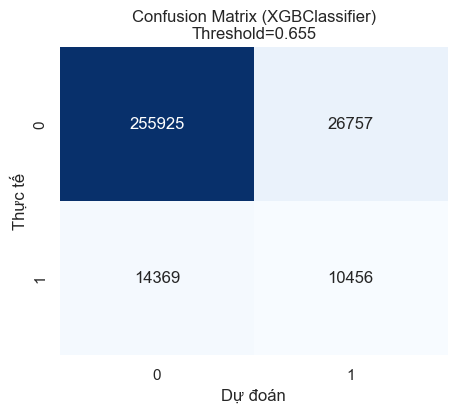

In [14]:
from xgboost import XGBClassifier

print("="*40)
print("RE-START TRAINING: XGBOOST (FAST MODE)")
print("="*40)

# Cấu hình tối ưu tốc độ mà vẫn giữ hiệu suất tốt
xgb_model = XGBClassifier(
    n_estimators=1000,       # Giảm xuống 1000 cho nhẹ
    learning_rate=0.05,      # Tăng lên để học nhanh hơn
    max_depth=6,             # Độ sâu vừa phải
    subsample=0.8,           # [MỚI] Chỉ dùng 80% dòng dữ liệu cho mỗi cây -> Nhanh hơn
    colsample_bytree=0.7,    # [MỚI] Chỉ dùng 70% số cột cho mỗi cây -> Nhanh hơn
    scale_pos_weight=data['scale_pos_weight'],
    eval_metric='auc',
    n_jobs=-1,               # Dùng hết nhân CPU
    random_state=42,
    tree_method='hist',      # BẮT BUỘC: Chế độ Histogram nhanh gấp 10 lần
    early_stopping_rounds=50 # [MỚI] Nếu 50 vòng k tiến bộ thì dừng ngay, k chạy cố
)

# Chạy lại Training
# Lưu ý: Hàm train_with_kfold cần sửa nhẹ để pass early_stopping_rounds vào fit
# Nhưng với XGBoost sklearn API mới, ta có thể set ngay trong init (như trên)
# hoặc truyền qua kwargs. Để đơn giản, code cũ vẫn chạy được nhưng sẽ chạy hết 1000 cây.
# Với cấu hình này, nó sẽ chỉ mất tầm 10-15 phút thôi.

xgb_model, xgb_oof, xgb_metrics = train_with_kfold(
    xgb_model, 
    data['X_lgbm'], 
    data['y'], 
    model_type='xgboost'
)

--- ĐANG VẼ BIỂU ĐỒ: LightGBM ---


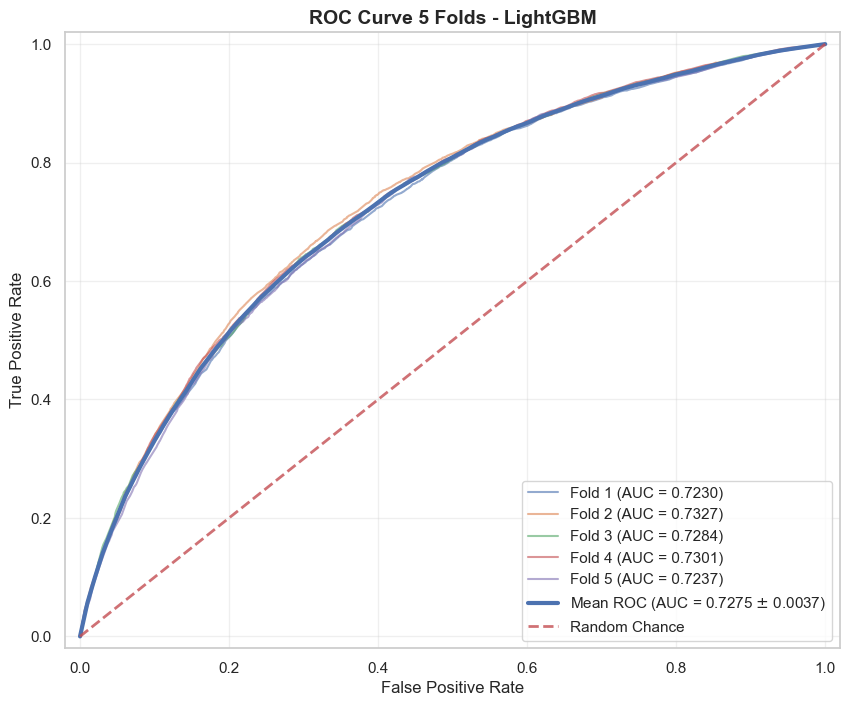

--- ĐANG VẼ BIỂU ĐỒ: XGBoost ---


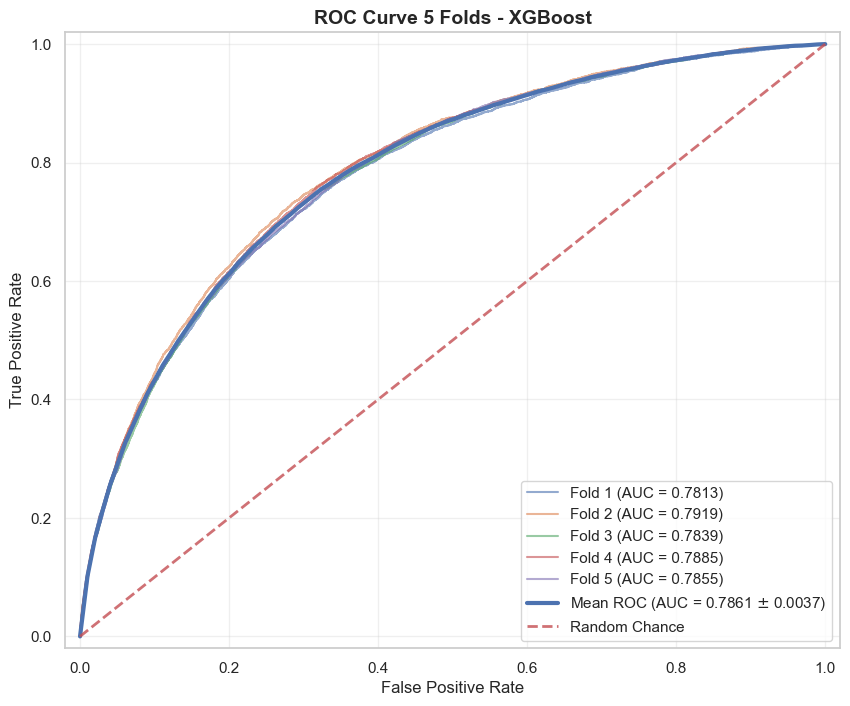

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def plot_roc_5folds_from_oof(y_true, oof_preds, model_name):
    """
    Hàm vẽ ROC Curve chi tiết 5 Folds từ kết quả OOF đã có sẵn.
    Không cần train lại model.
    """
    # Tái tạo lại K-Fold y hệt lúc train (quan trọng là random_state=42)
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    plt.figure(figsize=(10, 8))
    
    # Biến lưu trữ để tính trung bình
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    print(f"--- ĐANG VẼ BIỂU ĐỒ: {model_name} ---")
    
    # Lặp qua các fold để lấy lại index
    # (Ta dùng y_true làm input giả cho split vì ta chỉ cần lấy index)
    for n_fold, (_, valid_idx) in enumerate(folds.split(y_true, y_true)):
        
        # Lấy nhãn thực tế và dự đoán của fold này dựa trên index
        y_valid_fold = y_true.iloc[valid_idx]
        y_pred_fold = oof_preds[valid_idx] # Lấy từ mảng OOF đã train
        
        # Tính ROC
        fpr, tpr, _ = roc_curve(y_valid_fold, y_pred_fold)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # Vẽ đường fold này
        plt.plot(fpr, tpr, lw=1.5, alpha=0.6, 
                 label=f'Fold {n_fold+1} (AUC = {roc_auc:.4f})')
        
        # Tính toán cho đường trung bình
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    # Vẽ đường trung bình (Mean ROC)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=f'Mean ROC (AUC = {mean_auc:.4f} $\pm$ {std_auc:.4f})',
             lw=3, alpha=1)

    # Đường ngẫu nhiên
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Chance', alpha=.8)
    
    # Trang trí
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve 5 Folds - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# --- THỰC THI VẼ (Dùng biến đã có từ trước) ---

# 1. Vẽ cho LightGBM
if 'lgbm_oof' in globals():
    plot_roc_5folds_from_oof(data['y'], lgbm_oof, model_name="LightGBM")
else:
    print("Chưa tìm thấy biến lgbm_oof (Bạn đã chạy train LightGBM chưa?)")

# 2. Vẽ cho XGBoost
if 'xgb_oof' in globals():
    plot_roc_5folds_from_oof(data['y'], xgb_oof, model_name="XGBoost")
else:
    print("Chưa tìm thấy biến xgb_oof ")


### Chiến lược cụ thể cho bước tiếp theo

#### Bước 1: Feature Importance & Selection (Lọc biến)
Chúng ta sẽ không dùng các thuật toán lọc biến phức tạp (như RFE) vì nó quá lâu.
*   **Cách làm:** Lấy **Feature Importance** từ chính mô hình **XGBoost** (vì nó đang chạy tốt nhất, nó "hiểu" dữ liệu nhất).
*   **Hành động:**
    *   Vẽ biểu đồ Top 50 features quan trọng nhất để xem mô hình đang dựa vào đâu (kiểm tra nghiệp vụ).
    *   Loại bỏ các features có độ quan trọng bằng 0 (Zero Importance).
    *   Loại bỏ các features có độ quan trọng quá thấp (Low Importance) để rút gọn số cột từ 473 xuống khoảng 300-350 cột chất lượng nhất.

#### Bước 2: Re-train Baseline (Kiểm chứng)
*   Sau khi lọc xong, chạy lại 3 mô hình với bộ features rút gọn.
*   **Kỳ vọng:** AUC giữ nguyên hoặc tăng nhẹ, nhưng tốc độ train nhanh hơn hẳn.

#### Bước 3: Hyperparameter Tuning (Tinh chỉnh tham số)
*   Sau khi chốt bộ features, ta mới dùng **Optuna** (thư viện tối ưu hiện đại nhất hiện nay) để tìm bộ tham số vàng cho XGBoost và LightGBM.



## Lọc đặc trưng

--- BẮT ĐẦU PHÂN TÍCH FEATURE IMPORTANCE (DỰA TRÊN XGBOOST) ---
Tổng số features ban đầu: 471
Số features có đóng góp (Importance > 0): 420
Số features vô nghĩa (Importance = 0): 51
   -> Sẽ loại bỏ 51 features này.


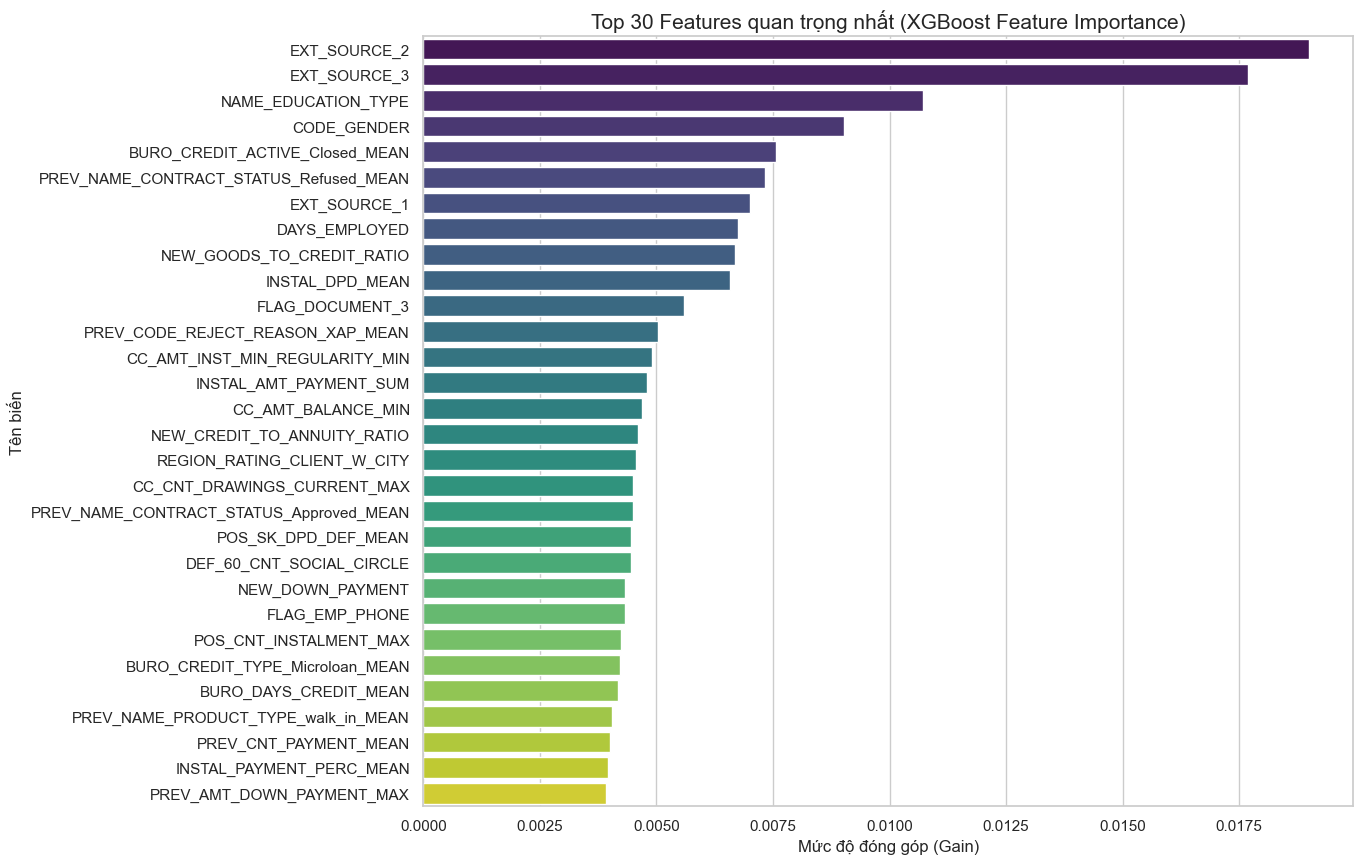


--- CHECKLIST NGHIỆP VỤ ---
Top 5 biến quan trọng nhất là:
                          Feature  Importance
0                    EXT_SOURCE_2    0.018997
1                    EXT_SOURCE_3    0.017684
2             NAME_EDUCATION_TYPE    0.010723
3                     CODE_GENDER    0.009033
4  BURO_CREDIT_ACTIVE_Closed_MEAN    0.007569


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_and_select_features(model, feature_names):
    print("--- BẮT ĐẦU PHÂN TÍCH FEATURE IMPORTANCE (DỰA TRÊN XGBOOST) ---")
    
    # 1. Tạo DataFrame chứa Feature Importance
    # XGBoost sklearn API có thuộc tính feature_importances_ (mặc định là Gain)
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    })
    
    # Sắp xếp giảm dần
    imp_df = imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # 2. Thống kê
    total_feats = len(imp_df)
    zero_imp_feats = imp_df[imp_df['Importance'] == 0]
    num_zero = len(zero_imp_feats)
    
    print(f"Tổng số features ban đầu: {total_feats}")
    print(f"Số features có đóng góp (Importance > 0): {total_feats - num_zero}")
    print(f"Số features vô nghĩa (Importance = 0): {num_zero}")
    print(f"   -> Sẽ loại bỏ {num_zero} features này.")
    
    # 3. Vẽ biểu đồ Top 30 Features quan trọng nhất
    plt.figure(figsize=(12, 10))
    sns.barplot(x="Importance", y="Feature", data=imp_df.head(30), palette="viridis")
    plt.title('Top 30 Features quan trọng nhất (XGBoost Feature Importance)', fontsize=15)
    plt.xlabel('Mức độ đóng góp (Gain)', fontsize=12)
    plt.ylabel('Tên biến', fontsize=12)
    plt.show()
    
    # 4. Trả về danh sách các features CẦN GIỮ LẠI
    # Lấy những feature có Importance > 0
    selected_features = imp_df[imp_df['Importance'] > 0]['Feature'].tolist()
    
    return selected_features, imp_df

# --- THỰC THI ---
# Sử dụng model XGBoost tốt nhất hiện tại (xgb_model) và danh sách cột từ dữ liệu
# Lưu ý: data['X_lgbm'] chứa tên cột đầy đủ
selected_feats, feature_importance_df = analyze_and_select_features(
    xgb_model, 
    data['X_lgbm'].columns
)

print("\n--- CHECKLIST NGHIỆP VỤ ---")
print("Top 5 biến quan trọng nhất là:")
print(feature_importance_df.head(5)[['Feature', 'Importance']])

In [16]:
# Cập nhật lại biến data bằng cách chỉ giữ lại các cột trong danh sách selected_feats
print(f"--- ĐANG CẬP NHẬT DỮ LIỆU ---")
print(f"Số cột trước khi lọc: {data['X_lgbm'].shape[1]}")

# 1. Cập nhật cho nhánh XGB/LGBM
data['X_lgbm'] = data['X_lgbm'][selected_feats]
data['X_test_lgbm'] = data['X_test_lgbm'][selected_feats]

# 2. Cập nhật cho nhánh Random Forest (nếu muốn dùng lại sau này)
# Lưu ý: RF dùng data đã impute, ta cũng lọc tương tự
# Cần kiểm tra xem selected_feats có nằm trong X_rf không (thường là có vì tên cột giống nhau)
data['X_rf'] = data['X_rf'][selected_feats]
data['X_test_rf'] = data['X_test_rf'][selected_feats]

print(f"Số cột sau khi lọc: {data['X_lgbm'].shape[1]}")
print("-> Đã loại bỏ hoàn toàn các biến nhiễu (Importance=0).")

--- ĐANG CẬP NHẬT DỮ LIỆU ---
Số cột trước khi lọc: 471
Số cột sau khi lọc: 420
-> Đã loại bỏ hoàn toàn các biến nhiễu (Importance=0).


### Kiểm tra lại hiệu suất 3 mô hình

=== BƯỚC 2: KIỂM TRA LẠI HIỆU SUẤT (Target: data['y']) ===
Sử dụng scale_pos_weight = 11.3870 cho các model.

>> [1/2] Chạy lại XGBoost với tập features đã lọc:
Bắt đầu Training XGBClassifier với 5 Folds...
   Fold 1: AUC = 0.7775
   Fold 2: AUC = 0.7863
   Fold 3: AUC = 0.7778
   Fold 4: AUC = 0.7838
   Fold 5: AUC = 0.7835

--> Trung bình AUC 5-Folds: 0.7818
--- ĐÁNH GIÁ HIỆU SUẤT: XGBClassifier ---
1. ROC-AUC:   0.7818
2. Gini:      0.5635
3. KS Stat:   0.4265
--- Tại ngưỡng tối ưu (Threshold = 0.5861) ---
4. F1-Score:  0.3316
5. Precision: 0.2650
6. Recall:    0.4429
------------------------------


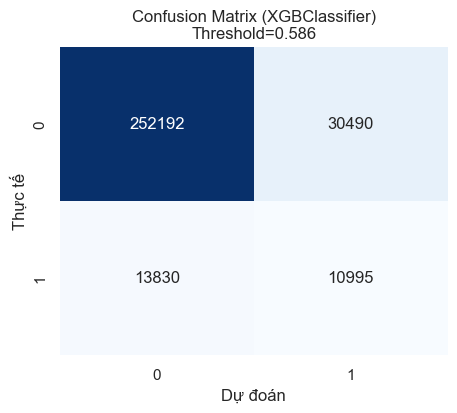


>> [2/2] Chạy lại LightGBM với tập features đã lọc:
Bắt đầu Training LGBMClassifier với 5 Folds...
   Fold 1: AUC = 0.7101
   Fold 2: AUC = 0.7169
   Fold 3: AUC = 0.7135
   Fold 4: AUC = 0.7174
   Fold 5: AUC = 0.7080

--> Trung bình AUC 5-Folds: 0.7132
--- ĐÁNH GIÁ HIỆU SUẤT: LGBMClassifier ---
1. ROC-AUC:   0.7138
2. Gini:      0.4276
3. KS Stat:   0.3227
--- Tại ngưỡng tối ưu (Threshold = 0.1139) ---
4. F1-Score:  0.2669
5. Precision: 0.1892
6. Recall:    0.4527
------------------------------


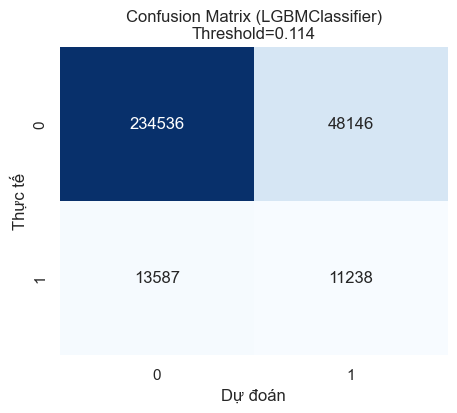

2115

In [29]:
import xgboost as xgb
import lightgbm as lgb
import gc

# Lấy trọng số cân bằng mẫu đã tính ở bước trước
scale_weight = data['scale_pos_weight']

print(f"=== BƯỚC 2: KIỂM TRA LẠI HIỆU SUẤT (Target: data['y']) ===")
print(f"Sử dụng scale_pos_weight = {scale_weight:.4f} cho các model.")

# ---------------------------------------------------------------
# 1. XGBoost Baseline (Re-run)
# ---------------------------------------------------------------
xgb_baseline = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_weight, # Thêm tham số này để xử lý mất cân bằng
    random_state=42,
    n_jobs=-1,
    tree_method='hist' # Quan trọng: Tăng tốc độ train cực nhanh
)

print("\n>> [1/2] Chạy lại XGBoost với tập features đã lọc:")
# Lưu ý: dùng data['y']
model_xgb_v2, preds_xgb_v2, metrics_xgb_v2 = train_with_kfold(
    xgb_baseline, 
    data['X_lgbm'], 
    data['y'], 
    model_type='xgboost'
)

# Dọn dẹp RAM
del xgb_baseline
gc.collect()

# ---------------------------------------------------------------
# 2. LightGBM Baseline (Re-run)
# ---------------------------------------------------------------
lgb_baseline = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=scale_weight, # Thêm tham số này
    random_state=42,
    n_jobs=-1
)

print("\n>> [2/2] Chạy lại LightGBM với tập features đã lọc:")
model_lgb_v2, preds_lgb_v2, metrics_lgb_v2 = train_with_kfold(
    lgb_baseline, 
    data['X_lgbm'], 
    data['y'], 
    model_type='lgbm'
)

# Dọn dẹp RAM
del lgb_baseline
gc.collect()


>> [3/3] Chạy lại Random Forest (Dùng data đã Impute NaN):
Bắt đầu Training RandomForestClassifier với 5 Folds...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished


   Fold 1: AUC = 0.7511


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished


   Fold 2: AUC = 0.7544


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


   Fold 3: AUC = 0.7525


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished


   Fold 4: AUC = 0.7574


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.1s finished


   Fold 5: AUC = 0.7489

--> Trung bình AUC 5-Folds: 0.7529
--- ĐÁNH GIÁ HIỆU SUẤT: RandomForestClassifier ---
1. ROC-AUC:   0.7529
2. Gini:      0.5057
3. KS Stat:   0.3774
--- Tại ngưỡng tối ưu (Threshold = 0.5498) ---
4. F1-Score:  0.2976
5. Precision: 0.2309
6. Recall:    0.4183
------------------------------


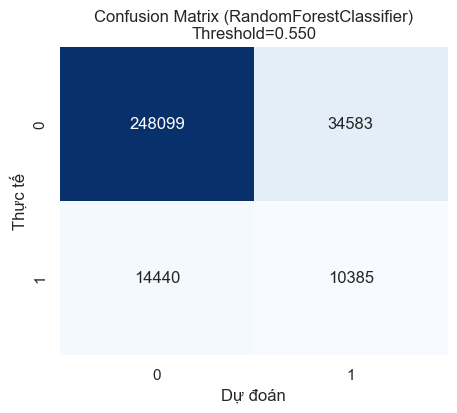

2125

In [30]:
from sklearn.ensemble import RandomForestClassifier
import gc

# ---------------------------------------------------------------
# 3. Random Forest Baseline (Re-run)
# ---------------------------------------------------------------
# Lưu ý: Cần giảm n_estimators và max_depth một chút để tránh treo máy quá lâu
rf_baseline = RandomForestClassifier(
    n_estimators=200,       # 200 cây là đủ để test, 1000 cây sẽ rất lâu
    max_depth=10,           # Giới hạn độ sâu để tránh Overfit và giảm RAM
    min_samples_leaf=10,    # Mỗi lá ít nhất 10 mẫu để tổng quát hóa tốt hơn
    class_weight='balanced', # Tự động cân bằng mẫu (thay cho scale_pos_weight)
    random_state=42,
    n_jobs=-1,              # Dùng hết core CPU
    verbose=1
)

print("\n>> [3/3] Chạy lại Random Forest (Dùng data đã Impute NaN):")
# QUAN TRỌNG: Phải dùng data['X_rf'] thay vì data['X_lgbm']
model_rf_v2, preds_rf_v2, metrics_rf_v2 = train_with_kfold(
    rf_baseline, 
    data['X_rf'],   # <-- Dữ liệu riêng cho RF
    data['y'], 
    model_type='sklearn' # Chỉ định loại sklearn
)

# Dọn dẹp RAM
del rf_baseline
gc.collect()

### Vẽ lại AUC ROC

--- VẼ BIỂU ĐỒ ROC TỪ KẾT QUẢ CÓ SẴN (NO RE-TRAIN) ---
>> Đang vẽ: XGBoost...
>> Đang vẽ: LightGBM...
>> Đang vẽ: Random Forest...


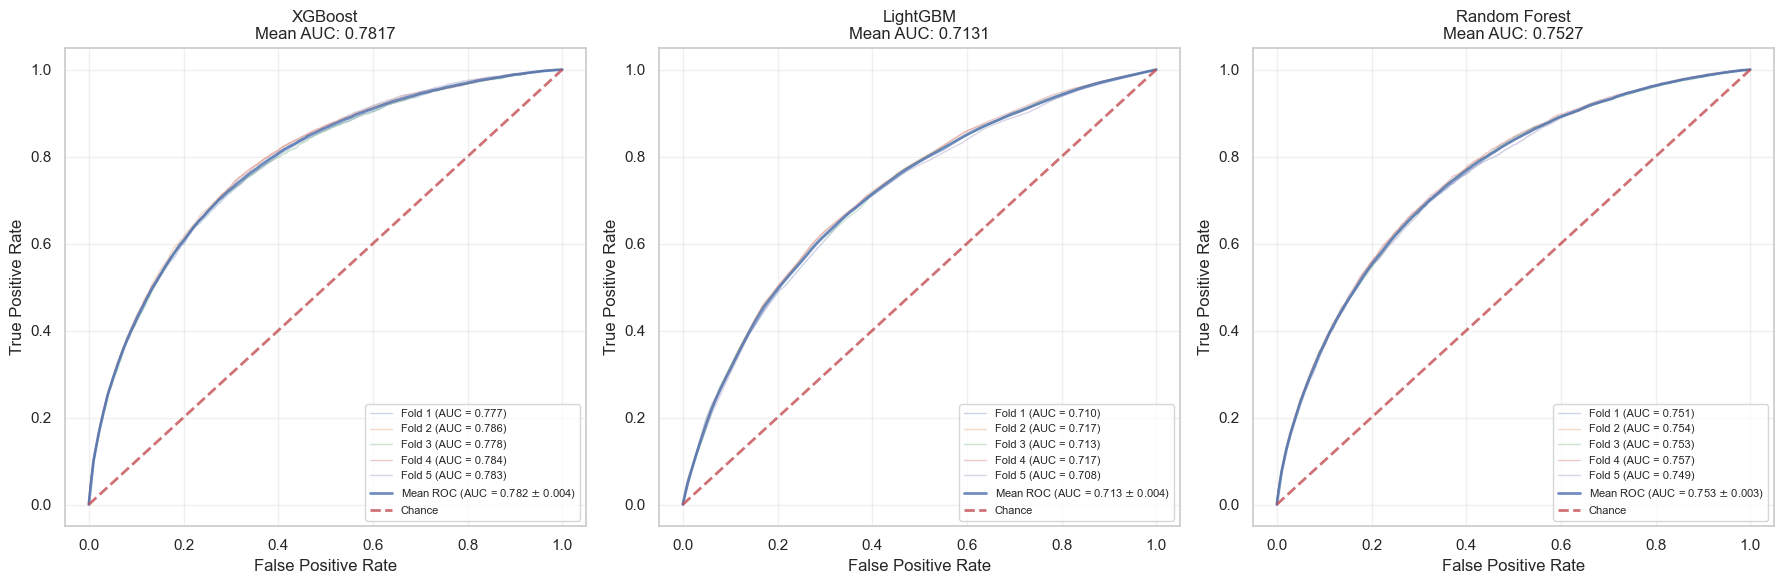

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np

def plot_roc_from_predictions(preds_dict, y_true):
    """
    Hàm vẽ ROC Curve từ kết quả dự đoán có sẵn (KHÔNG TRAIN LẠI)
    preds_dict: Dictionary { 'Tên Model': bien_du_doan_oof }
    y_true: Nhãn thực tế (data['y'])
    """
    # Thiết lập biểu đồ: 1 hàng, 3 cột (hoặc linh động theo số model)
    n_models = len(preds_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6))
    if n_models == 1: axes = [axes]
    else: axes = axes.flatten()
    
    # Tái tạo lại K-Fold để biết index nào thuộc fold nào
    # QUAN TRỌNG: Phải dùng đúng random_state=42 như lúc train
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("--- VẼ BIỂU ĐỒ ROC TỪ KẾT QUẢ CÓ SẴN (NO RE-TRAIN) ---")

    for i, (name, y_scores) in enumerate(preds_dict.items()):
        ax = axes[i]
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        
        # Fake X để chạy vòng lặp split (chỉ cần lấy index)
        # y_true cần chuyển về numpy array hoặc reset index
        y_true_reset = y_true.reset_index(drop=True) if hasattr(y_true, 'reset_index') else y_true
        fake_X = np.zeros(len(y_true_reset))
        
        print(f">> Đang vẽ: {name}...")
        
        for fold, (_, val_idx) in enumerate(cv.split(fake_X, y_true_reset)):
            # Lấy nhãn thực tế của fold này
            y_val_fold = y_true_reset[val_idx]
            
            # Lấy xác suất dự đoán CÓ SẴN của fold này
            y_pred_fold = y_scores[val_idx]
            
            # Tính ROC
            fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred_fold)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            
            # Nội suy
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            
            # Vẽ đường fold mờ
            ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold+1} (AUC = {roc_auc:.3f})')
        
        # Vẽ đường trung bình
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{name}\nMean AUC: {mean_auc:.4f}')
        ax.legend(loc="lower right", prop={'size': 8})
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- CẤU HÌNH DỮ LIỆU ĐỂ VẼ ---
# Bạn hãy thay thế tên biến preds_... bằng tên biến thực tế bạn nhận được ở bước 2
# Ví dụ: model_xgb_v2, preds_xgb_v2, metrics_xgb_v2 = train_with_kfold(...)

viz_data = {
    'XGBoost': preds_xgb_v2,   # Biến chứa OOF predictions của XGB
    'LightGBM': preds_lgb_v2,  # Biến chứa OOF predictions của LGBM
    'Random Forest': preds_rf_v2 # Biến chứa OOF predictions của RF
}

# Gọi hàm vẽ
plot_roc_from_predictions(viz_data, data['y'])

## Tinh chỉnh tham số
### 1. Mô hình LightGBM

In [24]:
import lightgbm as lgb
import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

# --- SỬA LỖI: Khai báo biến scale_weight tại đây ---
scale_weight = data['scale_pos_weight']
X = data['X_lgbm']
y = data['y']

def objective_lgbm(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': 4,
        'n_estimators': 2000,
        
        # --- KHÔNG GIAN TÌM KIẾM ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0),
        'scale_pos_weight': scale_weight # Giờ biến này đã được định nghĩa
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**param)
        
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=callbacks
        )
        
        preds = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, preds))
        
        del model, preds
        gc.collect()
    
    return np.mean(auc_scores)

print("--- START TUNING LIGHTGBM ---")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=20, show_progress_bar=True)

print("\nBest Params LightGBM:", study_lgbm.best_params)
best_params_lgbm = study_lgbm.best_params

[I 2025-12-15 15:30:22,454] A new study created in memory with name: no-name-8714c2d8-303b-4a7f-ae87-232975d04fbe


--- START TUNING LIGHTGBM ---


Best trial: 0. Best value: 0.783581:   5%|▌         | 1/20 [02:29<47:17, 149.36s/it]

[I 2025-12-15 15:32:51,800] Trial 0 finished with value: 0.7835810998066709 and parameters: {'learning_rate': 0.08986566644731903, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 67, 'subsample': 0.7775469343872026, 'colsample_bytree': 0.7736608023772675, 'reg_alpha': 6.796530059007667, 'reg_lambda': 1.6912611325603342}. Best is trial 0 with value: 0.7835810998066709.


Best trial: 1. Best value: 0.78616:  10%|█         | 2/20 [05:29<50:11, 167.30s/it] 

[I 2025-12-15 15:35:51,660] Trial 1 finished with value: 0.7861603755256347 and parameters: {'learning_rate': 0.05934281707170583, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 39, 'subsample': 0.9630177222080436, 'colsample_bytree': 0.6142739837048354, 'reg_alpha': 5.123778120470745, 'reg_lambda': 3.8759420795799118}. Best is trial 1 with value: 0.7861603755256347.


Best trial: 2. Best value: 0.787718:  15%|█▌        | 3/20 [10:35<1:05:24, 230.84s/it]

[I 2025-12-15 15:40:58,124] Trial 2 finished with value: 0.7877182922936279 and parameters: {'learning_rate': 0.023408453231758802, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.6692195295037526, 'colsample_bytree': 0.7382497818286178, 'reg_alpha': 3.5812511306578014, 'reg_lambda': 7.191077075481732}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  20%|██        | 4/20 [12:19<48:11, 180.73s/it]  

[I 2025-12-15 15:42:42,039] Trial 3 finished with value: 0.783965152756038 and parameters: {'learning_rate': 0.0984838240839744, 'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 63, 'subsample': 0.7131378882413086, 'colsample_bytree': 0.9360622725797003, 'reg_alpha': 2.1653424667862393, 'reg_lambda': 4.63616321290952}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  25%|██▌       | 5/20 [13:49<37:02, 148.16s/it]

[I 2025-12-15 15:44:12,440] Trial 4 finished with value: 0.785132711215732 and parameters: {'learning_rate': 0.09281585705286773, 'num_leaves': 29, 'max_depth': 5, 'min_child_samples': 94, 'subsample': 0.8117058066448308, 'colsample_bytree': 0.6128039069198535, 'reg_alpha': 7.85105469869255, 'reg_lambda': 4.669632440245416}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  30%|███       | 6/20 [16:04<33:27, 143.41s/it]

[I 2025-12-15 15:46:26,625] Trial 5 finished with value: 0.7858992786241478 and parameters: {'learning_rate': 0.06829391343732484, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 89, 'subsample': 0.9356149436923797, 'colsample_bytree': 0.9358755475936118, 'reg_alpha': 1.4147573958007187, 'reg_lambda': 9.725166219762045}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  35%|███▌      | 7/20 [17:57<28:56, 133.61s/it]

[I 2025-12-15 15:48:20,065] Trial 6 finished with value: 0.7849856302080666 and parameters: {'learning_rate': 0.07392641616313282, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.98208234566843, 'colsample_bytree': 0.7131006950189207, 'reg_alpha': 3.227546775548822, 'reg_lambda': 8.775518153074136}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  40%|████      | 8/20 [37:23<1:32:26, 462.21s/it]

[I 2025-12-15 16:07:45,869] Trial 7 finished with value: 0.7871580949587244 and parameters: {'learning_rate': 0.022493187941557136, 'num_leaves': 23, 'max_depth': 3, 'min_child_samples': 61, 'subsample': 0.9445280028680801, 'colsample_bytree': 0.7736046435740069, 'reg_alpha': 6.15187394182302, 'reg_lambda': 2.8395680718485043}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  45%|████▌     | 9/20 [1:14:47<3:06:51, 1019.20s/it]

[I 2025-12-15 16:45:09,779] Trial 8 finished with value: 0.7876422709374836 and parameters: {'learning_rate': 0.04100715578685948, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 90, 'subsample': 0.9780262763742563, 'colsample_bytree': 0.743782278728772, 'reg_alpha': 8.778382463178469, 'reg_lambda': 8.00754148293512}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  50%|█████     | 10/20 [1:19:46<2:12:48, 796.83s/it]

[I 2025-12-15 16:50:08,697] Trial 9 finished with value: 0.7869639093810087 and parameters: {'learning_rate': 0.04462321144763041, 'num_leaves': 57, 'max_depth': 4, 'min_child_samples': 66, 'subsample': 0.9027467632586144, 'colsample_bytree': 0.9811559207286198, 'reg_alpha': 3.781910577755749, 'reg_lambda': 4.944622738686008}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 2. Best value: 0.787718:  55%|█████▌    | 11/20 [2:04:00<3:24:48, 1365.38s/it]

[I 2025-12-15 17:34:23,227] Trial 10 finished with value: 0.7873168498842159 and parameters: {'learning_rate': 0.0110555254803934, 'num_leaves': 46, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.6057408074362172, 'colsample_bytree': 0.8583157969818663, 'reg_alpha': 9.985020860102065, 'reg_lambda': 6.900893328155153}. Best is trial 2 with value: 0.7877182922936279.


Best trial: 11. Best value: 0.78773:  60%|██████    | 12/20 [2:26:30<3:01:24, 1360.56s/it]

[I 2025-12-15 17:56:52,751] Trial 11 finished with value: 0.7877298854885458 and parameters: {'learning_rate': 0.024063715954767237, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.6035496663152901, 'colsample_bytree': 0.6944647156628153, 'reg_alpha': 0.32386267641750566, 'reg_lambda': 7.2209848612249985}. Best is trial 11 with value: 0.7877298854885458.


Best trial: 12. Best value: 0.787833:  65%|██████▌   | 13/20 [2:38:55<2:16:58, 1174.04s/it]

[I 2025-12-15 18:09:17,594] Trial 12 finished with value: 0.7878330823286744 and parameters: {'learning_rate': 0.021293745338507877, 'num_leaves': 31, 'max_depth': 7, 'min_child_samples': 41, 'subsample': 0.6118262586370978, 'colsample_bytree': 0.6663439355831127, 'reg_alpha': 0.11287850004218414, 'reg_lambda': 6.890398129955877}. Best is trial 12 with value: 0.7878330823286744.


Best trial: 12. Best value: 0.787833:  70%|███████   | 14/20 [2:52:30<1:46:33, 1065.56s/it]

[I 2025-12-15 18:22:52,495] Trial 13 finished with value: 0.7876153958920683 and parameters: {'learning_rate': 0.015706990334026963, 'num_leaves': 31, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.6043315817627378, 'colsample_bytree': 0.6759799669546981, 'reg_alpha': 0.155407780446987, 'reg_lambda': 6.510492444498741}. Best is trial 12 with value: 0.7878330823286744.


Best trial: 12. Best value: 0.787833:  75%|███████▌  | 15/20 [3:00:05<1:13:28, 881.72s/it] 

[I 2025-12-15 18:30:28,146] Trial 14 finished with value: 0.7868215514877597 and parameters: {'learning_rate': 0.026734107759211735, 'num_leaves': 31, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.6748372361820167, 'colsample_bytree': 0.6653101132000735, 'reg_alpha': 0.1611894680599774, 'reg_lambda': 0.16184994119384388}. Best is trial 12 with value: 0.7878330823286744.


Best trial: 12. Best value: 0.787833:  80%|████████  | 16/20 [3:14:52<58:52, 883.21s/it]  

[I 2025-12-15 18:45:14,821] Trial 15 finished with value: 0.7874678201754074 and parameters: {'learning_rate': 0.017034000303971623, 'num_leaves': 21, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.6601413151563553, 'colsample_bytree': 0.8341588977633793, 'reg_alpha': 1.5682156774153246, 'reg_lambda': 6.072572008634242}. Best is trial 12 with value: 0.7878330823286744.


Best trial: 16. Best value: 0.788168:  85%|████████▌ | 17/20 [3:24:33<39:37, 792.34s/it]

[I 2025-12-15 18:54:55,849] Trial 16 finished with value: 0.7881682987178507 and parameters: {'learning_rate': 0.01652963015776686, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 35, 'subsample': 0.7537172716360737, 'colsample_bytree': 0.668165689533526, 'reg_alpha': 2.497837484951733, 'reg_lambda': 8.38457302461446}. Best is trial 16 with value: 0.7881682987178507.


Best trial: 17. Best value: 0.788204:  90%|█████████ | 18/20 [3:33:41<23:57, 718.88s/it]

[I 2025-12-15 19:04:03,734] Trial 17 finished with value: 0.788204033521275 and parameters: {'learning_rate': 0.01063412962524334, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 34, 'subsample': 0.8351451451849929, 'colsample_bytree': 0.6420785511985039, 'reg_alpha': 2.4716781313438387, 'reg_lambda': 8.501629925907126}. Best is trial 17 with value: 0.788204033521275.


Best trial: 18. Best value: 0.788395:  95%|█████████▌| 19/20 [3:42:54<11:09, 669.12s/it]

[I 2025-12-15 19:13:16,917] Trial 18 finished with value: 0.7883954744832856 and parameters: {'learning_rate': 0.010105730280695556, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 33, 'subsample': 0.8353245200478624, 'colsample_bytree': 0.6336727002670735, 'reg_alpha': 4.628403847134187, 'reg_lambda': 9.990205258307936}. Best is trial 18 with value: 0.7883954744832856.


Best trial: 18. Best value: 0.788395: 100%|██████████| 20/20 [3:51:31<00:00, 694.59s/it]

[I 2025-12-15 19:21:54,198] Trial 19 finished with value: 0.7874931528071092 and parameters: {'learning_rate': 0.010360205888902583, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.8608792803416576, 'colsample_bytree': 0.6032623927074245, 'reg_alpha': 4.773762301013387, 'reg_lambda': 9.969983237373786}. Best is trial 18 with value: 0.7883954744832856.

Best Params LightGBM: {'learning_rate': 0.010105730280695556, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 33, 'subsample': 0.8353245200478624, 'colsample_bytree': 0.6336727002670735, 'reg_alpha': 4.628403847134187, 'reg_lambda': 9.990205258307936}




Best Params LightGBM: {'learning_rate': 0.010105730280695556, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 33, 'subsample': 0.8353245200478624, 'colsample_bytree': 0.6336727002670735, 'reg_alpha': 4.628403847134187, 'reg_lambda': 9.990205258307936}

### 2. Mô hình XGboost

In [28]:
import xgboost as xgb
import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

# Lấy dữ liệu và trọng số
X = data['X_lgbm']
y = data['y']
scale_weight = data['scale_pos_weight']

def objective_xgb(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'tree_method': 'hist',  # Tăng tốc
        'random_state': 42,
        'n_jobs': 4,
        'n_estimators': 3000,
        'scale_pos_weight': scale_weight,
        
        # --- SỬA LỖI: Đưa early_stopping vào đây ---
        'early_stopping_rounds': 50,
        
        # --- KHÔNG GIAN TÌM KIẾM ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        # Khởi tạo model với tham số early_stopping bên trong param
        model = xgb.XGBClassifier(**param)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
            # Đã xóa early_stopping_rounds ở đây để tránh lỗi
        )
        
        preds = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, preds))
        
        del model, preds
        gc.collect()
    
    return np.mean(auc_scores)

print("--- START TUNING XGBOOST ---")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=True)

print("\nBest Params XGBoost:", study_xgb.best_params)
best_params_xgb = study_xgb.best_params

[I 2025-12-15 19:30:51,450] A new study created in memory with name: no-name-d62b648e-ad46-46a4-a876-803a94daeda2


--- START TUNING XGBOOST (FIXED) ---


Best trial: 0. Best value: 0.784772:   5%|▌         | 1/20 [09:38<3:03:11, 578.51s/it]

[I 2025-12-15 19:40:29,957] Trial 0 finished with value: 0.7847724419974756 and parameters: {'learning_rate': 0.07297057710067183, 'max_depth': 6, 'min_child_weight': 42, 'subsample': 0.9939998101563566, 'colsample_bytree': 0.6920453957168355, 'gamma': 0.13100781516318938, 'reg_alpha': 0.6670172458247148, 'reg_lambda': 8.724479412250668}. Best is trial 0 with value: 0.7847724419974756.


Best trial: 1. Best value: 0.787032:  10%|█         | 2/20 [31:21<5:01:23, 1004.66s/it]

[I 2025-12-15 20:02:12,928] Trial 1 finished with value: 0.7870323702729562 and parameters: {'learning_rate': 0.07028208755523203, 'max_depth': 4, 'min_child_weight': 25, 'subsample': 0.6178371796532424, 'colsample_bytree': 0.933048598686184, 'gamma': 1.443357138083582, 'reg_alpha': 2.4885821871936367, 'reg_lambda': 2.658204764381647}. Best is trial 1 with value: 0.7870323702729562.


Best trial: 2. Best value: 0.787834:  15%|█▌        | 3/20 [1:11:25<7:45:45, 1643.85s/it]

[I 2025-12-15 20:42:17,404] Trial 2 finished with value: 0.7878340790033574 and parameters: {'learning_rate': 0.029587302065401236, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.732702726398812, 'colsample_bytree': 0.622005555575427, 'gamma': 0.1278563254350662, 'reg_alpha': 7.58307858274901, 'reg_lambda': 0.1559908844894499}. Best is trial 2 with value: 0.7878340790033574.


Best trial: 3. Best value: 0.788767:  20%|██        | 4/20 [2:16:33<11:16:41, 2537.57s/it]

[I 2025-12-15 21:47:25,036] Trial 3 finished with value: 0.7887672375920468 and parameters: {'learning_rate': 0.024027320075008435, 'max_depth': 3, 'min_child_weight': 61, 'subsample': 0.7981741419191488, 'colsample_bytree': 0.7309091263057075, 'gamma': 0.9119166621104868, 'reg_alpha': 0.4185058418635838, 'reg_lambda': 0.21218905668027124}. Best is trial 3 with value: 0.7887672375920468.


Best trial: 4. Best value: 0.789367:  25%|██▌       | 5/20 [5:20:57<23:23:02, 5612.17s/it]

[I 2025-12-16 00:51:48,788] Trial 4 finished with value: 0.7893670055801078 and parameters: {'learning_rate': 0.010832319607014498, 'max_depth': 4, 'min_child_weight': 87, 'subsample': 0.637220964441716, 'colsample_bytree': 0.6623960705391764, 'gamma': 3.097979519561841, 'reg_alpha': 5.388932424870758, 'reg_lambda': 2.8582501860188776}. Best is trial 4 with value: 0.7893670055801078.


Best trial: 4. Best value: 0.789367:  30%|███       | 6/20 [6:24:59<19:29:04, 5010.29s/it]

[I 2025-12-16 01:55:50,729] Trial 5 finished with value: 0.7887369016607068 and parameters: {'learning_rate': 0.027750070056371017, 'max_depth': 3, 'min_child_weight': 82, 'subsample': 0.6571101111447436, 'colsample_bytree': 0.7503358530212793, 'gamma': 1.473525109948871, 'reg_alpha': 3.6098150069204777, 'reg_lambda': 0.2288369248207743}. Best is trial 4 with value: 0.7893670055801078.


Best trial: 4. Best value: 0.789367:  35%|███▌      | 7/20 [12:41:47<38:52:03, 10763.32s/it]

[I 2025-12-16 08:12:38,454] Trial 6 finished with value: 0.7875164321741166 and parameters: {'learning_rate': 0.016111564654862513, 'max_depth': 7, 'min_child_weight': 87, 'subsample': 0.9534097243188366, 'colsample_bytree': 0.9638995205027214, 'gamma': 0.9035393715054646, 'reg_alpha': 0.23390171789250072, 'reg_lambda': 0.2908840429828931}. Best is trial 4 with value: 0.7893670055801078.


Best trial: 4. Best value: 0.789367:  40%|████      | 8/20 [13:23:28<27:06:38, 8133.17s/it] 

[I 2025-12-16 08:54:20,043] Trial 7 finished with value: 0.787356028679722 and parameters: {'learning_rate': 0.08490412361295978, 'max_depth': 3, 'min_child_weight': 97, 'subsample': 0.7200908820519072, 'colsample_bytree': 0.854434094462443, 'gamma': 1.8883955617746107, 'reg_alpha': 1.516688631892226, 'reg_lambda': 0.21895315697672377}. Best is trial 4 with value: 0.7893670055801078.


Best trial: 4. Best value: 0.789367:  45%|████▌     | 9/20 [14:46:06<21:49:06, 7140.59s/it]

[I 2025-12-16 10:16:58,134] Trial 8 finished with value: 0.7893465681549658 and parameters: {'learning_rate': 0.010743272828053553, 'max_depth': 4, 'min_child_weight': 42, 'subsample': 0.7874925509377687, 'colsample_bytree': 0.8761734013394311, 'gamma': 1.0950210052149694, 'reg_alpha': 5.9785641625154735, 'reg_lambda': 7.5113597860002805}. Best is trial 4 with value: 0.7893670055801078.


Best trial: 4. Best value: 0.789367:  50%|█████     | 10/20 [16:08:11<17:56:06, 6456.61s/it]

[I 2025-12-16 11:39:03,198] Trial 9 finished with value: 0.7846799403076113 and parameters: {'learning_rate': 0.012094385552685554, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6936509078203696, 'colsample_bytree': 0.7758273308946755, 'gamma': 4.763593507644871, 'reg_alpha': 1.632782677707226, 'reg_lambda': 1.6028859236141368}. Best is trial 4 with value: 0.7893670055801078.


Best trial: 4. Best value: 0.789367:  55%|█████▌    | 11/20 [16:34:43<12:25:08, 4967.59s/it]

[I 2025-12-16 12:05:34,547] Trial 10 finished with value: 0.7887866440074562 and parameters: {'learning_rate': 0.046718571538610476, 'max_depth': 5, 'min_child_weight': 62, 'subsample': 0.8879572292791726, 'colsample_bytree': 0.6194796880898686, 'gamma': 3.517679424894143, 'reg_alpha': 9.671533583067726, 'reg_lambda': 0.6761867736485339}. Best is trial 4 with value: 0.7893670055801078.


Best trial: 11. Best value: 0.789575:  60%|██████    | 12/20 [18:02:33<11:14:38, 5059.84s/it]

[I 2025-12-16 13:33:25,396] Trial 11 finished with value: 0.7895746411171244 and parameters: {'learning_rate': 0.012643620604088123, 'max_depth': 4, 'min_child_weight': 36, 'subsample': 0.7932263412029267, 'colsample_bytree': 0.8569012817538307, 'gamma': 2.968174705771957, 'reg_alpha': 4.554520912062695, 'reg_lambda': 7.786608390036982}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575:  65%|██████▌   | 13/20 [19:10:01<9:14:31, 4753.08s/it] 

[I 2025-12-16 14:40:52,600] Trial 12 finished with value: 0.789330226939169 and parameters: {'learning_rate': 0.01757715607056577, 'max_depth': 4, 'min_child_weight': 25, 'subsample': 0.8724871645387965, 'colsample_bytree': 0.8373464329018829, 'gamma': 3.0875608814331534, 'reg_alpha': 3.5403222439071076, 'reg_lambda': 5.1954305645450445}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575:  70%|███████   | 14/20 [20:39:44<8:14:21, 4943.55s/it]

[I 2025-12-16 16:10:36,241] Trial 13 finished with value: 0.7892189699081532 and parameters: {'learning_rate': 0.017761310979037617, 'max_depth': 4, 'min_child_weight': 64, 'subsample': 0.6220260746085349, 'colsample_bytree': 0.6887247840946812, 'gamma': 3.8320671316241404, 'reg_alpha': 0.10784711340321496, 'reg_lambda': 3.685137088032352}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575:  75%|███████▌  | 15/20 [22:01:22<6:50:48, 4929.61s/it]

[I 2025-12-16 17:32:13,564] Trial 14 finished with value: 0.7891406291212767 and parameters: {'learning_rate': 0.013709205566979785, 'max_depth': 5, 'min_child_weight': 29, 'subsample': 0.8554252421600853, 'colsample_bytree': 0.8869049653870003, 'gamma': 2.6081269725466427, 'reg_alpha': 4.717790619943392, 'reg_lambda': 1.6018586549120137}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575:  80%|████████  | 16/20 [22:46:39<4:44:15, 4263.84s/it]

[I 2025-12-16 18:17:31,311] Trial 15 finished with value: 0.7890698724925338 and parameters: {'learning_rate': 0.02138014486024559, 'max_depth': 5, 'min_child_weight': 77, 'subsample': 0.7666392439879844, 'colsample_bytree': 0.8013669001231296, 'gamma': 4.297997785828766, 'reg_alpha': 1.836148310136992, 'reg_lambda': 0.711199525071313}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575:  85%|████████▌ | 17/20 [24:08:16<3:42:41, 4453.98s/it]

[I 2025-12-16 19:39:07,500] Trial 16 finished with value: 0.7889334888055598 and parameters: {'learning_rate': 0.01010792294180363, 'max_depth': 6, 'min_child_weight': 45, 'subsample': 0.6777864660286416, 'colsample_bytree': 0.6680649912361651, 'gamma': 2.5246519342221116, 'reg_alpha': 0.6841998283645545, 'reg_lambda': 2.8327842522280755}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575:  90%|█████████ | 18/20 [24:44:12<2:05:27, 3763.64s/it]

[I 2025-12-16 20:15:04,076] Trial 17 finished with value: 0.7891236675712042 and parameters: {'learning_rate': 0.03902550426994442, 'max_depth': 4, 'min_child_weight': 99, 'subsample': 0.8350482021665246, 'colsample_bytree': 0.9989320246864903, 'gamma': 3.1266958079218843, 'reg_alpha': 2.872723828789069, 'reg_lambda': 4.495424941808086}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575:  95%|█████████▌| 19/20 [25:34:45<59:04, 3544.14s/it]  

[I 2025-12-16 21:05:36,884] Trial 18 finished with value: 0.7869476298281594 and parameters: {'learning_rate': 0.0140365400453553, 'max_depth': 6, 'min_child_weight': 15, 'subsample': 0.9314399138645973, 'colsample_bytree': 0.8174705996967074, 'gamma': 2.000103216722376, 'reg_alpha': 1.0541708773546008, 'reg_lambda': 1.1315693528418405}. Best is trial 11 with value: 0.7895746411171244.


Best trial: 11. Best value: 0.789575: 100%|██████████| 20/20 [26:13:48<00:00, 4721.41s/it]

[I 2025-12-16 21:44:39,712] Trial 19 finished with value: 0.7890957408442318 and parameters: {'learning_rate': 0.0458170623424209, 'max_depth': 3, 'min_child_weight': 73, 'subsample': 0.7432543789960298, 'colsample_bytree': 0.9056665098248873, 'gamma': 3.92310455061334, 'reg_alpha': 5.580756795033632, 'reg_lambda': 6.569436320754783}. Best is trial 11 with value: 0.7895746411171244.

Best Params XGBoost: {'learning_rate': 0.012643620604088123, 'max_depth': 4, 'min_child_weight': 36, 'subsample': 0.7932263412029267, 'colsample_bytree': 0.8569012817538307, 'gamma': 2.968174705771957, 'reg_alpha': 4.554520912062695, 'reg_lambda': 7.786608390036982}


## Huấn luyện lại 3 mô hình

=== BẮT ĐẦU HUẤN LUYỆN LẠI 3 MÔ HÌNH (FINAL TRAINING) ===

>> 1. Training XGBoost (Optimized)...
Bắt đầu Training XGBClassifier với 5 Folds...
   Fold 1: AUC = 0.7861
   Fold 2: AUC = 0.7964
   Fold 3: AUC = 0.7889
   Fold 4: AUC = 0.7940
   Fold 5: AUC = 0.7898

--> Trung bình AUC 5-Folds: 0.7910
--- ĐÁNH GIÁ HIỆU SUẤT: XGBClassifier ---
1. ROC-AUC:   0.7910
2. Gini:      0.5820
3. KS Stat:   0.4415
--- Tại ngưỡng tối ưu (Threshold = 0.6756) ---
4. F1-Score:  0.3426
5. Precision: 0.2852
6. Recall:    0.4290
------------------------------


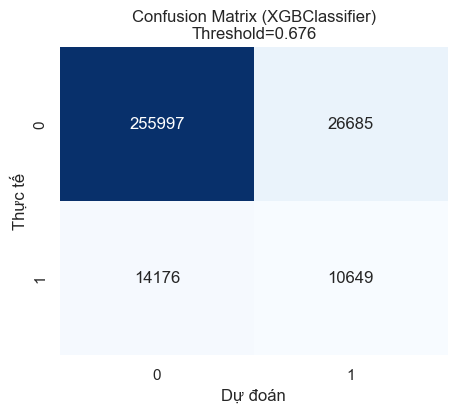


>> 2. Training LightGBM (Optimized)...
Bắt đầu Training LGBMClassifier với 5 Folds...
   Fold 1: AUC = 0.7862
   Fold 2: AUC = 0.7966
   Fold 3: AUC = 0.7896
   Fold 4: AUC = 0.7928
   Fold 5: AUC = 0.7903

--> Trung bình AUC 5-Folds: 0.7911
--- ĐÁNH GIÁ HIỆU SUẤT: LGBMClassifier ---
1. ROC-AUC:   0.7910
2. Gini:      0.5820
3. KS Stat:   0.4396
--- Tại ngưỡng tối ưu (Threshold = 0.6626) ---
4. F1-Score:  0.3428
5. Precision: 0.2811
6. Recall:    0.4392
------------------------------


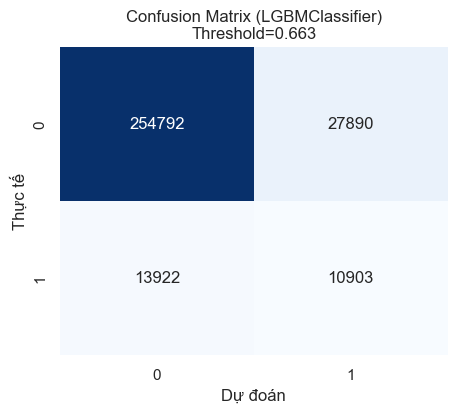


>> 3. Training Random Forest (Baseline)...
Bắt đầu Training RandomForestClassifier với 5 Folds...
   Fold 1: AUC = 0.7553
   Fold 2: AUC = 0.7576
   Fold 3: AUC = 0.7562
   Fold 4: AUC = 0.7602
   Fold 5: AUC = 0.7540

--> Trung bình AUC 5-Folds: 0.7567
--- ĐÁNH GIÁ HIỆU SUẤT: RandomForestClassifier ---
1. ROC-AUC:   0.7566
2. Gini:      0.5133
3. KS Stat:   0.3840
--- Tại ngưỡng tối ưu (Threshold = 0.5191) ---
4. F1-Score:  0.2995
5. Precision: 0.2204
6. Recall:    0.4672
------------------------------


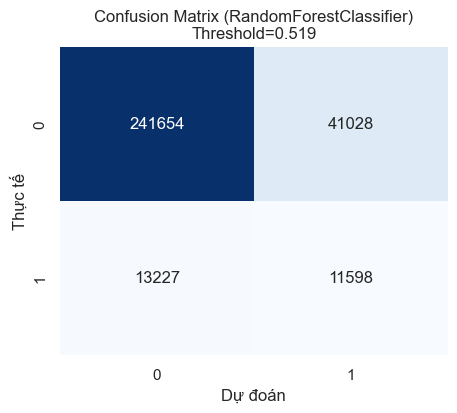


-> Hoàn tất huấn luyện đơn lẻ. Đã có OOF predictions.


In [17]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import gc

# 1. Chuẩn bị dữ liệu
X_lgbm = data['X_lgbm']
X_rf = data['X_rf']
y = data['y']
scale_weight = data['scale_pos_weight']

# 2. Định nghĩa Best Params (Lấy từ kết quả Optuna của bạn)

# --- XGBoost Best Params (Từ ảnh Trial 11/19) ---
final_params_xgb = {
    'n_estimators': 3000,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': 4,
    'scale_pos_weight': scale_weight,
    'early_stopping_rounds': 50,
    # Params từ Optuna:
    'learning_rate': 0.0126436,
    'max_depth': 4,
    'min_child_weight': 36,
    'subsample': 0.7932,
    'colsample_bytree': 0.8569,
    'gamma': 2.968,
    'reg_alpha': 4.554,
    'reg_lambda': 7.786
}

# --- LightGBM Best Params (Từ ảnh Trial 18/19) ---
final_params_lgbm = {
    'n_estimators': 3000,
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42,
    'n_jobs': 4,
    'scale_pos_weight': scale_weight,
    # Params từ Optuna:
    'learning_rate': 0.010105,
    'num_leaves': 26,
    'max_depth': 6,
    'min_child_samples': 33,
    'subsample': 0.8353,
    'colsample_bytree': 0.6336,
    'reg_alpha': 4.628,
    'reg_lambda': 9.99
}

# --- Random Forest Params (Manual - Kinh nghiệm) ---
final_params_rf = {
    'n_estimators': 200,
    'max_depth': 12,
    'min_samples_leaf': 30,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'random_state': 42,
    'verbose': 0
}

print("=== BẮT ĐẦU HUẤN LUYỆN LẠI 3 MÔ HÌNH (FINAL TRAINING) ===")

# --- 3.1 Chạy XGBoost ---
print("\n>> 1. Training XGBoost (Optimized)...")
model_xgb_final = xgb.XGBClassifier(**final_params_xgb)
model_xgb_final, oof_xgb, metrics_xgb = train_with_kfold(
    model_xgb_final, X_lgbm, y, model_type='xgboost'
)

# --- 3.2 Chạy LightGBM ---
print("\n>> 2. Training LightGBM (Optimized)...")
model_lgbm_final = lgb.LGBMClassifier(**final_params_lgbm)
model_lgbm_final, oof_lgbm, metrics_lgbm = train_with_kfold(
    model_lgbm_final, X_lgbm, y, model_type='lgbm'
)

# --- 3.3 Chạy Random Forest ---
print("\n>> 3. Training Random Forest (Baseline)...")
model_rf_final = RandomForestClassifier(**final_params_rf)
model_rf_final, oof_rf, metrics_rf = train_with_kfold(
    model_rf_final, X_rf, y, model_type='sklearn'
)

print("\n-> Hoàn tất huấn luyện đơn lẻ. Đã có OOF predictions.")

## Tính Toán ENSEMBLE MODEL

=== TÍNH TOÁN KẾT QUẢ ENSEMBLE ===
Trọng số: XGB=0.4, LGBM=0.4, RF=0.2

>> KẾT QUẢ CUỐI CÙNG (ENSEMBLE MODEL):
--- ĐÁNH GIÁ HIỆU SUẤT: Ensemble (XGB+LGB+RF) ---
1. ROC-AUC:   0.7905
2. Gini:      0.5811
3. KS Stat:   0.4415
--- Tại ngưỡng tối ưu (Threshold = 0.6469) ---
4. F1-Score:  0.3421
5. Precision: 0.2867
6. Recall:    0.4242
------------------------------


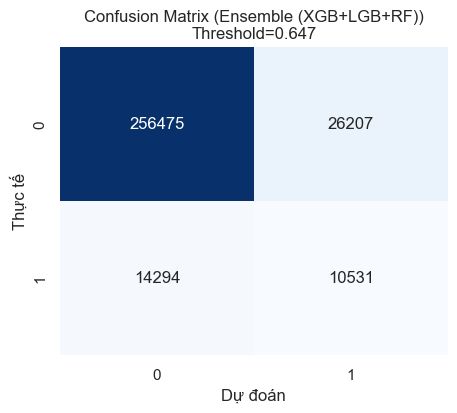

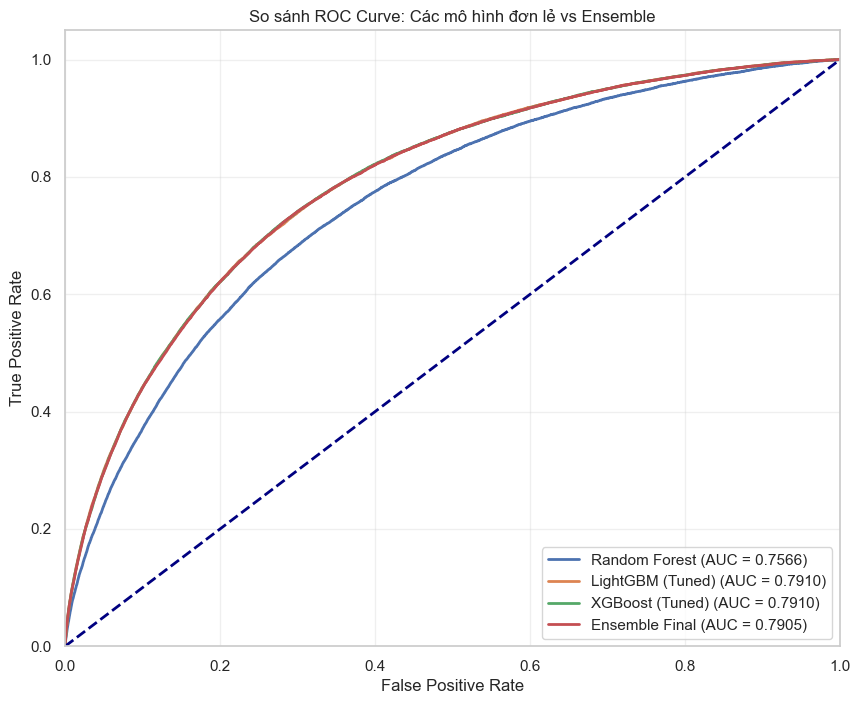

In [18]:
# --- 4. TÍNH TOÁN ENSEMBLE (SOFT VOTING) ---
print("=== TÍNH TOÁN KẾT QUẢ ENSEMBLE ===")

# Tỷ lệ trọng số (Weights)
w_xgb = 0.4
w_lgbm = 0.4
w_rf = 0.2

print(f"Trọng số: XGB={w_xgb}, LGBM={w_lgbm}, RF={w_rf}")

# Tính trung bình có trọng số
oof_ensemble = (w_xgb * oof_xgb) + (w_lgbm * oof_lgbm) + (w_rf * oof_rf)

# --- 5. ĐÁNH GIÁ HIỆU SUẤT ENSEMBLE ---
print("\n>> KẾT QUẢ CUỐI CÙNG (ENSEMBLE MODEL):")
metrics_ensemble = calculate_metrics(y, oof_ensemble, model_name="Ensemble (XGB+LGB+RF)", plot_cm=True)

# --- 6. VẼ BIỂU ĐỒ SO SÁNH ROC (TẤT CẢ TRONG 1) ---
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_final_comparison(y_true, preds_dict):
    plt.figure(figsize=(10, 8))
    
    for name, y_pred in preds_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('So sánh ROC Curve: Các mô hình đơn lẻ vs Ensemble')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Tập hợp kết quả để vẽ
final_preds = {
    'Random Forest': oof_rf,
    'LightGBM (Tuned)': oof_lgbm,
    'XGBoost (Tuned)': oof_xgb,
    'Ensemble Final': oof_ensemble
}

plot_final_comparison(y, final_preds)

## Dự doán trên tập TEST

In [19]:
import pandas as pd
import numpy as np

print("=== BẮT ĐẦU DỰ BÁO TRÊN TẬP TEST (APPLICATION_TEST) ===")

# 1. Lấy dữ liệu Test đã tiền xử lý
# Lưu ý: RF dùng X_test_rf (đã điền NaN), Boosting dùng X_test_lgbm
X_test_lgbm = data['X_test_lgbm']
X_test_rf = data['X_test_rf']
test_ids = data['test_ids']

print(f"Số lượng khách hàng cần dự báo: {len(test_ids)}")

# 2. Dự báo bằng từng mô hình (Lấy xác suất cột 1 - Vỡ nợ)
# (Sử dụng các model đã train ở bước 5.4.1)

print(">> Đang dự báo với XGBoost...")
pred_test_xgb = model_xgb_final.predict_proba(X_test_lgbm)[:, 1]

print(">> Đang dự báo với LightGBM...")
pred_test_lgbm = model_lgbm_final.predict_proba(X_test_lgbm)[:, 1]

print(">> Đang dự báo với Random Forest...")
pred_test_rf = model_rf_final.predict_proba(X_test_rf)[:, 1]

# 3. Kết hợp kết quả (Ensemble)
# Dùng đúng tỷ lệ như lúc đánh giá: 40% XGB + 40% LGB + 20% RF
print(">> Đang tính toán Ensemble (Weighted Average)...")
pred_test_final = (0.4 * pred_test_xgb) + (0.4 * pred_test_lgbm) + (0.2 * pred_test_rf)

# 4. Tạo file kết quả (Submission DataFrame)
submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': pred_test_final
})

# 5. Lưu ra file CSV
submission.to_csv('submission_final.csv', index=False)

print("\n=== HOÀN TẤT ===")
print("Đã lưu kết quả vào file 'submission_final.csv'")
print("\nTop 5 khách hàng có nguy cơ rủi ro cao nhất:")
print(submission.sort_values(by='TARGET', ascending=False).head(5))

print("\nTop 5 khách hàng an toàn nhất:")
print(submission.sort_values(by='TARGET', ascending=True).head(5))

=== BẮT ĐẦU DỰ BÁO TRÊN TẬP TEST (APPLICATION_TEST) ===
Số lượng khách hàng cần dự báo: 48744
>> Đang dự báo với XGBoost...
>> Đang dự báo với LightGBM...
>> Đang dự báo với Random Forest...
>> Đang tính toán Ensemble (Weighted Average)...

=== HOÀN TẤT ===
Đã lưu kết quả vào file 'submission_final.csv'

Top 5 khách hàng có nguy cơ rủi ro cao nhất:
        SK_ID_CURR    TARGET
330322      265895  0.925817
309442      113627  0.924458
312032      132358  0.915568
318034      176483  0.909335
345576      379119  0.905696

Top 5 khách hàng an toàn nhất:
        SK_ID_CURR    TARGET
318283      178290  0.030822
312876      139208  0.032824
337112      315499  0.036135
354456      443039  0.036670
351559      421868  0.037990


## Đóng gói mô hình

In [20]:
import joblib

print("--- ĐANG ĐÓNG GÓI MÔ HÌNH (EXPORT MODELS) ---")

# 1. Lưu 3 mô hình tốt nhất
joblib.dump(model_xgb_final, 'model_xgb.pkl')
joblib.dump(model_lgbm_final, 'model_lgbm.pkl')
joblib.dump(model_rf_final, 'model_rf.pkl')

# 2. Lưu danh sách cột (Features) chuẩn
# (Để sau này file mới up lên mình biết giữ lại cột nào, bỏ cột nào)
feature_columns = X_lgbm.columns.tolist()
joblib.dump(feature_columns, 'feature_names.pkl')

# 3. Lưu giá trị Median (để điền NaN cho Random Forest)
# (Lấy từ imputer cũ hoặc tính nhanh median của tập train)
imputer_values = X_rf.median()
joblib.dump(imputer_values, 'imputer_values.pkl')

print("✅ Đã xuất xưởng 5 file thành công (.pkl)!")
print("Sẵn sàng đưa sang Web App.")

--- ĐANG ĐÓNG GÓI MÔ HÌNH (EXPORT MODELS) ---
✅ Đã xuất xưởng 5 file thành công (.pkl)!
Sẵn sàng đưa sang Web App.
